**Importing Libraries**

In [ ]:
import pandas as pd
from numpy import NaN
import spacy
from transformers import pipeline
import re
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Attention, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from transformers import TFRobertaModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from google.colab import drive

#drive.mount('/content/drive')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

**Pre-processing and Cleaning**

In [ ]:
# Preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        # remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)
        # convert to lowercase
        text = text.lower()
        # tokenize text
        tokens = nltk.word_tokenize(text)
        # remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        # lemmatize text
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # join tokens back into text
        text = ' '.join(tokens)
    return text

file_path = '/content/influencer_tweets.csv'

df = pd.read_csv(file_path,encoding='ISO-8859-1')

df = df.dropna(subset=['full_text'])


df['full_text'] = df['full_text'].fillna('')
df['full_text'] = df['full_text'].str.lower()
df['clean_text'] = df['full_text'].apply(preprocess_text)

In [ ]:
import pandas as pd

# Converting the "created_at" column to datetime format with the correct date format
df['created_at'] = pd.to_datetime(df['created_at'], format='%d-%m-%Y')
df['created_at'] = df['created_at'].dt.strftime('%Y-%m-%d')


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'created_at', 'favorite_count', 'full_text', 'hashtags/0',
       'hashtags/1', 'hashtags/2', 'id', 'is_retweet', 'media/0/media_url',
       'quoted_tweet/created_at', 'quoted_tweet/favorite_count',
       'quoted_tweet/full_text', 'quoted_tweet/hashtags/0',
       'quoted_tweet/hashtags/1', 'quoted_tweet/user/description',
       'user/created_at', 'user/description', 'user/favourites_count',
       'user/followers_count', 'user/listed_count', 'user/media_count',
       'user/name', 'user/normal_followers_count', 'user/screen_name',
       'user/statuses_count', 'user/url', 'importance_coefficient',
       'importance_coefficient_normalized', 'clean_text', 'reply_count',
       'retweet_count'],
      dtype='object')


In [ ]:
df.shape

(40066, 32)

Dropping uncecessary columns

In [ ]:
selected_columns = ['clean_text', 'created_at']
df_selected = df[selected_columns]

print(df_selected)

                                              clean_text  created_at
0      privacy human right learn make bitcoin transac...  2021-02-01
1      overall btc trading volume increased average t...  2021-02-01
2      average return distribution btc skews slightly...  2021-02-01
3      latest report research hub gda_capital talk se...  2021-02-01
4      sent httpstcomfyrz35zjf givedirectly great wor...  2021-02-01
...                                                  ...         ...
40061  rt crypto_crib_ altcoin market capãâ 145b sinc...  2023-06-12
40062  rt knveth fumbling generational wealth part lo...  2023-06-12
40063  rt crypto_crib_ pakistan ditched u dollar paid...  2023-06-12
40064  rt crypto_crib_ jpmorgan call comprehensive fr...  2023-06-12
40065  trending usãâââºãâââ congressman file legislat...  2023-06-12

[40066 rows x 2 columns]


**Filtering non-english words**

Tweets are filtered out using the langdetect library. Tweets are checked for language using the detect() method. If the language is not English, the tweet is skipped. Otherwise, the tweet is added to the list of tweets.




In [ ]:
import pandas as pd
import langdetect
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

selected_columns = ['clean_text', 'created_at']
df_selected = df[selected_columns]

def filter_non_english(text):
    try:
        if detect(text) == 'en':
            return True
        else:
            return False
    except LangDetectException:
        return False

df_selected = df_selected[df_selected['clean_text'].apply(filter_non_english)]

print(df_selected)

                                              clean_text  created_at
0      privacy human right learn make bitcoin transac...  2021-02-01
1      overall btc trading volume increased average t...  2021-02-01
2      average return distribution btc skews slightly...  2021-02-01
3      latest report research hub gda_capital talk se...  2021-02-01
4      sent httpstcomfyrz35zjf givedirectly great wor...  2021-02-01
...                                                  ...         ...
40061  rt crypto_crib_ altcoin market capãâ 145b sinc...  2023-06-12
40062  rt knveth fumbling generational wealth part lo...  2023-06-12
40063  rt crypto_crib_ pakistan ditched u dollar paid...  2023-06-12
40064  rt crypto_crib_ jpmorgan call comprehensive fr...  2023-06-12
40065  trending usãâââºãâââ congressman file legislat...  2023-06-12

[32598 rows x 2 columns]


In [ ]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=9fff0b9cf2e9f4d73f0b2c9b880e9fe87affe878760ecd53a34dff28af568a5b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


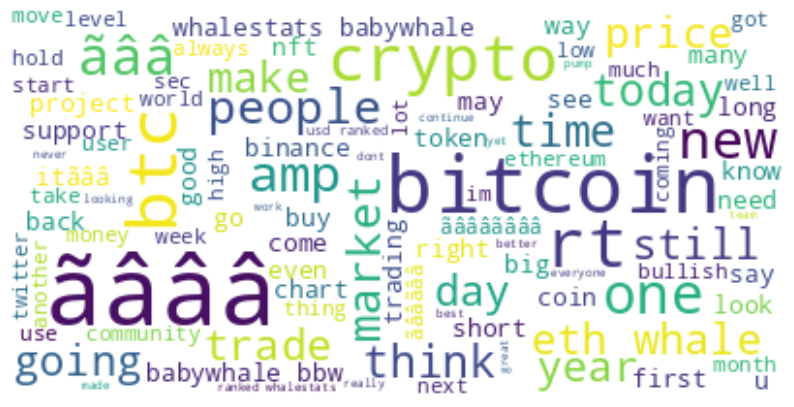

In [ ]:
# Generate WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = " ".join(tweet for tweet in df_selected['clean_text'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Removing Symbols

In [ ]:
import pandas as pd
import re

df_selected['clean_text'] = df_selected['clean_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

print(df_selected['clean_text'])

0        privacy human right learn make bitcoin transac...
1        overall btc trading volume increased average t...
2        average return distribution btc skews slightly...
3        latest report research hub gda_capital talk se...
4        sent httpstcomfyrz35zjf givedirectly great wor...
                               ...                        
40061    rt crypto_crib_ altcoin market capãâ 145b sinc...
40062    rt knveth fumbling generational wealth part lo...
40063    rt crypto_crib_ pakistan ditched u dollar paid...
40064    rt crypto_crib_ jpmorgan call comprehensive fr...
40065    trending usãâââºãâââ congressman file legislat...
Name: clean_text, Length: 32598, dtype: object


In [ ]:
df_selected['clean_text'] = df_selected['clean_text'].str.replace('ãâââ', '')
df_selected['clean_text'] = df_selected['clean_text'].str.replace('ãââ', '')
df_selected['clean_text'] = df_selected['clean_text'].str.replace('ãâ', '')
df_selected['clean_text'] = df_selected['clean_text'].str.replace('rt', '')
df_selected['clean_text'] = df_selected['clean_text'].str.replace('http', '')
df_selected['clean_text'] = df_selected['clean_text'].str.replace('usãâââºãâââ', '')
df_selected['clean_text'] = df_selected['clean_text'].str.replace('_', '')
df_selected['clean_text'] = df_selected['clean_text'].str.replace('º', '')

In [ ]:
print(df_selected['clean_text'])

0        privacy human right learn make bitcoin transac...
1        overall btc trading volume increased average t...
2        average return distribution btc skews slightly...
3        latest repo research hub gdacapital talk secur...
4        sent stcomfyrz35zjf givedirectly great work di...
                               ...                        
40061     cryptocrib altcoin market cap 145b since mid ...
40062     knveth fumbling generational wealth pa lore b...
40063     cryptocrib pakistan ditched u dollar paid fir...
40064     cryptocrib jpmorgan call comprehensive framew...
40065    trending us congressman file legislation fire ...
Name: clean_text, Length: 32598, dtype: object


In [ ]:
import pandas as pd
from collections import Counter
import re

words = ' '.join(df_selected['clean_text']).split()
word_count = Counter(words)

print("Top 10 most used words:")
for word, count in word_count.most_common(10):
    print(f"{word}: {count}")


Top 10 most used words:
bitcoin: 4188
crypto: 3501
btc: 3224
eth: 2607
market: 2461
time: 2284
new: 1843
one: 1822
see: 1810
amp: 1744


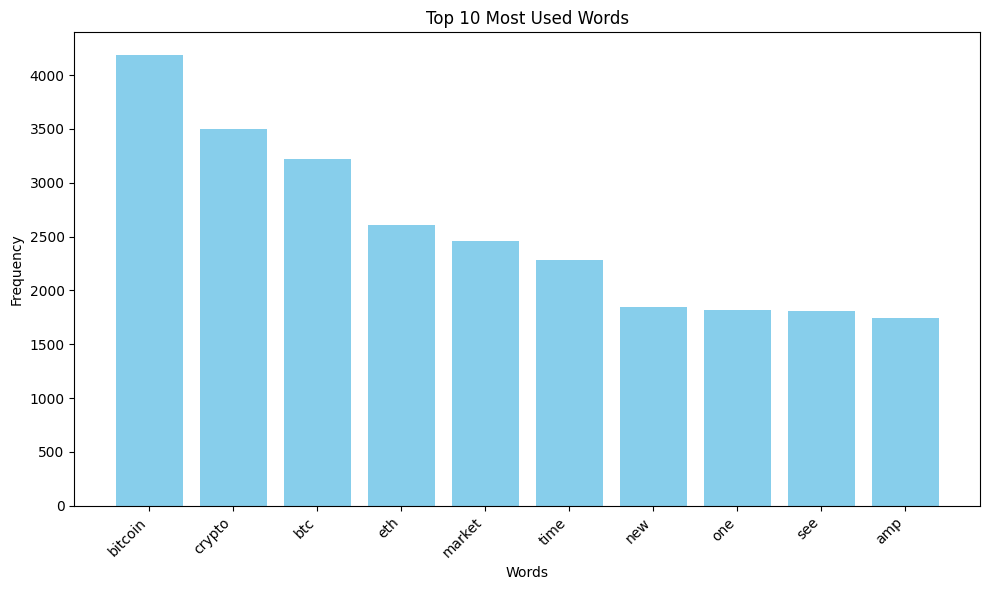

In [ ]:
# Top 10 most used words
top_10_words = dict(word_count.most_common(10))

plt.figure(figsize=(10,6))
plt.bar(top_10_words.keys(), top_10_words.values(), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Used Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Sentiment Analysis**

In [ ]:
from textblob import TextBlob


def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df_selected['sentiment'] = df_selected['clean_text'].apply(get_sentiment)

print(df_selected[['clean_text', 'sentiment']])

                                              clean_text sentiment
0      privacy human right learn make bitcoin transac...  positive
1      overall btc trading volume increased average t...  negative
2      average return distribution btc skews slightly...  positive
3      latest repo research hub gdacapital talk secur...  positive
4      sent stcomfyrz35zjf givedirectly great work di...  positive
...                                                  ...       ...
40061   cryptocrib altcoin market cap 145b since mid ...   neutral
40062   knveth fumbling generational wealth pa lore b...  positive
40063   cryptocrib pakistan ditched u dollar paid fir...  positive
40064   cryptocrib jpmorgan call comprehensive framew...  negative
40065  trending us congressman file legislation fire ...  negative

[32598 rows x 2 columns]


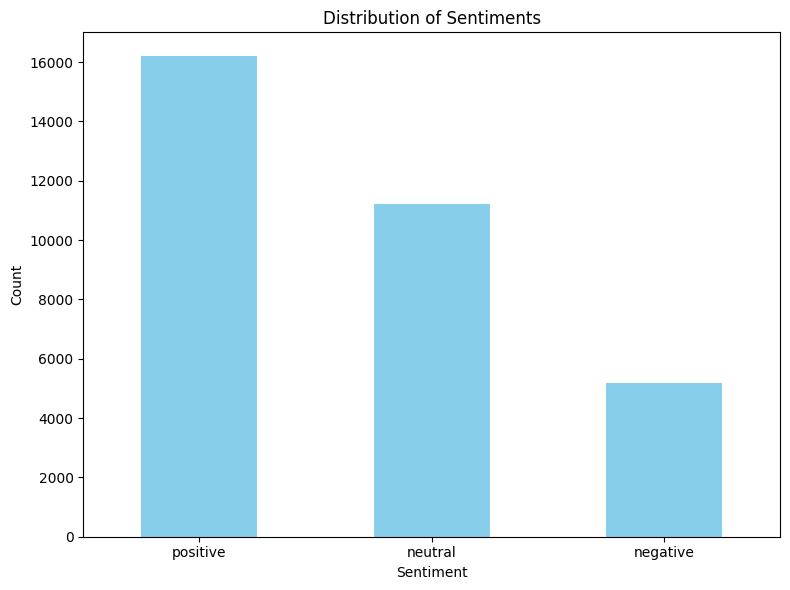

In [ ]:
import matplotlib.pyplot as plt

sentiment_counts = df_selected['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print(df_selected.head())

                                          clean_text  created_at sentiment  \
0  privacy human right learn make bitcoin transac...  2021-02-01  positive   
1  overall btc trading volume increased average t...  2021-02-01  negative   
2  average return distribution btc skews slightly...  2021-02-01  positive   
3  latest repo research hub gdacapital talk secur...  2021-02-01  positive   
4  sent stcomfyrz35zjf givedirectly great work di...  2021-02-01  positive   

                                            pos_tags  
0  [(privacy, NN), (human, JJ), (right, NN), (lea...  
1  [(overall, JJ), (btc, NN), (trading, NN), (vol...  
2  [(average, JJ), (return, NN), (distribution, N...  
3  [(latest, JJS), (repo, NN), (research, NN), (h...  
4  [(sent, NN), (stcomfyrz35zjf, NN), (givedirect...  


In [ ]:
print(df_selected.columns)

Index(['clean_text', 'created_at', 'sentiment', 'pos_tags'], dtype='object')


**Topic Modeling**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english')

# Fit and transform the 'clean_text' column to create a document-term matrix
dtm = vectorizer.fit_transform(df_selected['clean_text'])

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)

# Fit the LDA model to the document-term matrix
lda_model.fit(dtm)

def display_topics(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        print(f"Topic {index + 1}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print()

# Display the topics
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, n_top_words)


Topic 1:
['eth', 'whale', 'whalestats', 'bbw', '100', 'babywhale', 'bought', 'transaction', 'usd', 'ranked']

Topic 2:
['token', 'trading', 'new', 'user', 'liquidity', 'wallet', 'amp', 'live', 'nft', 'launch']

Topic 3:
['people', 'crypto', 'dont', 'good', 'time', 'market', 'make', 'going', 'know', 'money']

Topic 4:
['btc', 'bitcoin', 'price', 'sho', 'update', 'look', 'cha', 'level', 'low', 'time']

Topic 5:
['crypto', 'bitcoin', 'binance', 'sec', 'bank', 'new', 'amp', 'market', 'asset', 'project']



In [ ]:
def display_topics_with_names(model, feature_names, n_top_words, topic_names):
    for index, topic in enumerate(model.components_):
        print(f"Topic {index + 1} - {topic_names[index]}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print()


topic_names = [
    "Ethereum Whale Acitvity",
    "Crypto Trading and Launches",
    "General Crypto Sentiment",
    "Bitcoin Market Analysis",
    "Crypto News"
]


display_topics_with_names(lda_model, feature_names, n_top_words, topic_names)


Topic 1 - Ethereum Whale Acitvity:
['eth', 'whale', 'whalestats', 'bbw', '100', 'babywhale', 'bought', 'transaction', 'usd', 'ranked']

Topic 2 - Crypto Trading and Launches:
['token', 'trading', 'new', 'user', 'liquidity', 'wallet', 'amp', 'live', 'nft', 'launch']

Topic 3 - General Crypto Sentiment:
['people', 'crypto', 'dont', 'good', 'time', 'market', 'make', 'going', 'know', 'money']

Topic 4 - Bitcoin Market Analysis:
['btc', 'bitcoin', 'price', 'sho', 'update', 'look', 'cha', 'level', 'low', 'time']

Topic 5 - Crypto News:
['crypto', 'bitcoin', 'binance', 'sec', 'bank', 'new', 'amp', 'market', 'asset', 'project']



Topic Distribution

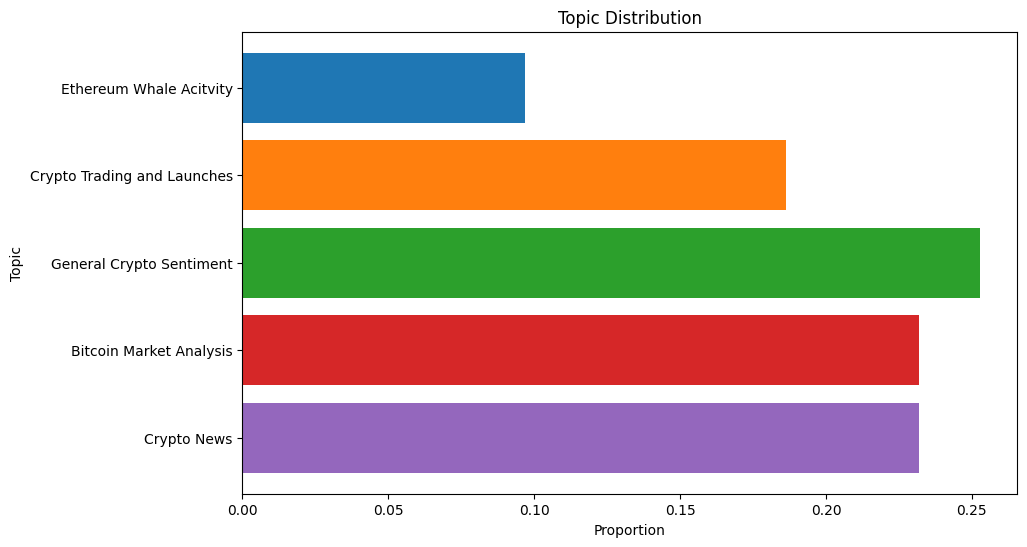

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_topic_distribution(model, feature_names, n_top_words):
    topic_distribution = []
    for topic in model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_distribution.append(top_words)
    return topic_distribution

topic_distribution = calculate_topic_distribution(lda_model, feature_names, n_top_words)

plt.figure(figsize=(10, 6))
for index, topic_name in enumerate(topic_names):
    plt.barh(topic_name, lda_model.transform(dtm)[:, index].mean())
plt.xlabel('Proportion')
plt.ylabel('Topic')
plt.title('Topic Distribution')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import numpy as np

def calculate_topic_distribution(model, feature_names, n_top_words):
    topic_distribution = []
    for topic in model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_distribution.append(top_words)
    return topic_distribution

def calculate_topic_proportions(lda_model, dtm):
    return lda_model.transform(dtm)

# Function to assign topics to tweets based on topic proportions
def assign_topics(topic_proportions):
    return np.argmax(topic_proportions, axis=1)

# Calculate topic proportions for each tweet
topic_proportions = calculate_topic_proportions(lda_model, dtm)

# Assign topics to tweets
df_selected['topic'] = assign_topics(topic_proportions)

print(df_selected[['clean_text', 'topic']])


                                              clean_text  topic
0      privacy human right learn make bitcoin transac...      4
1      overall btc trading volume increased average t...      3
2      average return distribution btc skews slightly...      3
3      latest repo research hub gdacapital talk secur...      4
4      sent stcomfyrz35zjf givedirectly great work di...      4
...                                                  ...    ...
40061   cryptocrib altcoin market cap 145b since mid ...      3
40062   knveth fumbling generational wealth pa lore b...      2
40063   cryptocrib pakistan ditched u dollar paid fir...      1
40064   cryptocrib jpmorgan call comprehensive framew...      4
40065  trending us congressman file legislation fire ...      4

[32598 rows x 2 columns]


**Getting bitcoin prices**

In [ ]:
import yfinance as yf


ticker_symbol = "BTC-USD"

start_date = "2020-01-01"
end_date = "2024-04-16"

btc_data = yf.download(ticker_symbol, start=start_date, end=end_date)

print(btc_data)

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2020-01-01   7194.892090   7254.330566   7174.944336   7200.174316   
2020-01-02   7202.551270   7212.155273   6935.270020   6985.470215   
2020-01-03   6984.428711   7413.715332   6914.996094   7344.884277   
2020-01-04   7345.375488   7427.385742   7309.514160   7410.656738   
2020-01-05   7410.451660   7544.497070   7400.535645   7411.317383   
...                  ...           ...           ...           ...   
2024-04-11  70575.734375  71256.234375  69571.812500  70060.609375   
2024-04-12  70061.382812  71222.742188  65254.835938  67195.867188   
2024-04-13  67188.375000  67931.429688  60919.105469  63821.472656   
2024-04-14  63836.230469  65824.429688  62205.851562  65738.726562   
2024-04-15  65739.648438  66878.648438  62332.070312  63426.210938   

               Adj Close       Volume  
Date                                   
2020-01-0

In [ ]:
pip install yfinance

In [ ]:
import pandas as pd

date_column = df_selected['created_at']

# Find the minimum and maximum dates in the dataset
start_date = date_column.min()
end_date = date_column.max()

print("Start Date:", start_date)
print("End Date:", end_date)


Start Date: 2021-02-01
End Date: 2023-06-12


In [ ]:
import yfinance as yf

ticker_symbol = "BTC-USD"

start_date = "2021-02-01"
end_date = "2023-06-12"

btc_data = yf.download(ticker_symbol, start=start_date, end=end_date)

print(btc_data)

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2021-02-01  33114.578125  34638.214844  32384.228516  33537.175781   
2021-02-02  33533.199219  35896.882812  33489.218750  35510.289062   
2021-02-03  35510.820312  37480.187500  35443.984375  37472.089844   
2021-02-04  37475.105469  38592.175781  36317.500000  36926.066406   
2021-02-05  36931.546875  38225.906250  36658.761719  38144.308594   
...                  ...           ...           ...           ...   
2023-06-07  27235.650391  27332.181641  26146.988281  26345.998047   
2023-06-08  26347.654297  26797.513672  26246.664062  26508.216797   
2023-06-09  26505.923828  26770.289062  26339.314453  26480.375000   
2023-06-10  26481.761719  26531.044922  25501.835938  25851.240234   
2023-06-11  25854.031250  26203.439453  25668.986328  25940.167969   

               Adj Close       Volume  
Date                                   
2021-02-0

**Merging the datasets**

In [ ]:
df_selected['created_at'] = pd.to_datetime(df_selected['created_at'])

In [ ]:
merged_data = pd.merge(df_selected, btc_data, left_on='created_at', right_index=True, how='inner')

In [ ]:
print(merged_data.head)

<bound method NDFrame.head of                                               clean_text created_at sentiment  \
0      privacy human right learn make bitcoin transac... 2021-02-01  positive   
1      overall btc trading volume increased average t... 2021-02-01  negative   
2      average return distribution btc skews slightly... 2021-02-01  positive   
3      latest repo research hub gdacapital talk secur... 2021-02-01  positive   
4      sent stcomfyrz35zjf givedirectly great work di... 2021-02-01  positive   
...                                                  ...        ...       ...   
39672  sentiment way high bottom put actually shocked... 2023-06-11  negative   
39673  altcoin market cap look heavy right wouldnt ag... 2023-06-11  positive   
39674  75th othersidemeta locked absolute beauty deed... 2023-06-11  positive   
39675  cpi fomc next week prepare arsehole ¼ stcogyk4... 2023-06-11   neutral   
39677  took people week realize ive arguing bot comme... 2023-06-11  negative  

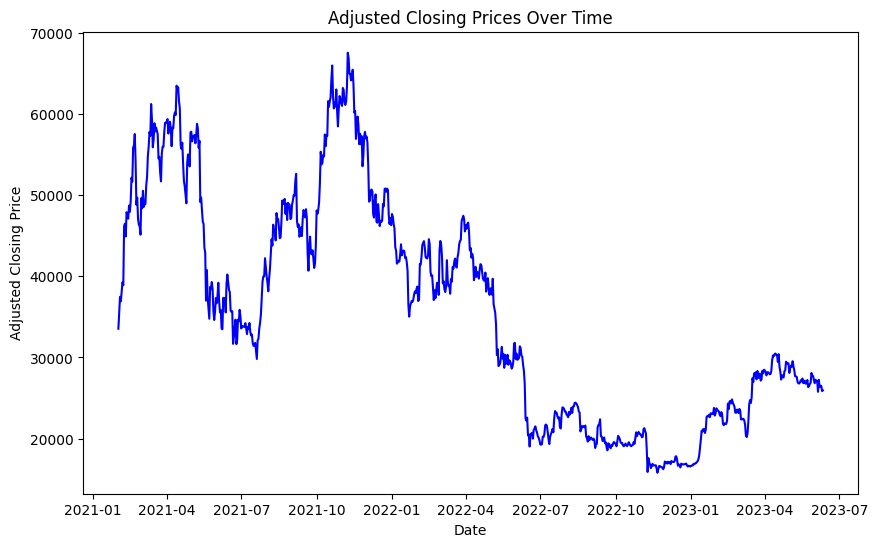

In [ ]:
# Time Series Analysis
plt.figure(figsize=(10, 6))
plt.plot(merged_data['created_at'], merged_data['Adj Close'], color='blue')
plt.title('Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.show()

In [ ]:
print(merged_data.columns)

Index(['clean_text', 'created_at', 'sentiment', 'pos_tags', 'topic', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype='object')


**Topic Prevalance**

Calculate topic prevalence over time and examine how the prevalence of specific topics correlates with fluctuations in Bitcoin price.

In [ ]:
import pandas as pd
import numpy as np


# 1. Aggregate topic prevalence and Bitcoin price data over the same time intervals
topic_prevalence = merged_data.groupby('created_at')['topic'].value_counts(normalize=True).unstack(fill_value=0)
bitcoin_price = merged_data.groupby('created_at')[['Close']].mean()

# 2. Calculate correlation coefficients between topic prevalence and Bitcoin price
correlation_matrix = topic_prevalence.corrwith(bitcoin_price['Close'])

print("Correlation Coefficients:")
print(correlation_matrix)


Correlation Coefficients:
topic
0   -0.148296
1    0.083005
2   -0.287846
3   -0.158206
4    0.338748
dtype: float64


Topics with negative correlations have inverse relationship with bitcoin prices.

A coefficient of -0.287846 for Topic 2(Crypto trading and launches) suggests a moderate negative correlation, indicating that as the prevalence of Topic 2 increases in social media discussions, Bitcoin prices tend to decrease.

A coefficient of 0.338748 for Topic 4(Bitcoin market analysis) suggests a moderate positive correlation, indicating that as the prevalence of Topic 4 increases in social media discussions, Bitcoin prices tend to increase

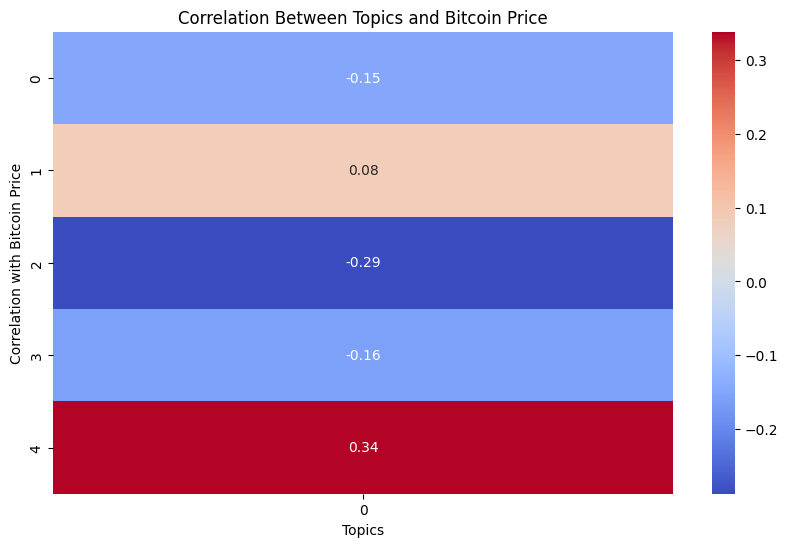

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

topic_prevalence = merged_data.groupby('created_at')['topic'].value_counts(normalize=True).unstack(fill_value=0)
bitcoin_price = merged_data.groupby('created_at')[['Close']].mean()

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(topic_prevalence.corrwith(bitcoin_price['Close']).to_frame(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between Topics and Bitcoin Price')
plt.xlabel('Topics')
plt.ylabel('Correlation with Bitcoin Price')
plt.show()


Top keywords in topic 4

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt


topic_4_tweets = merged_data[merged_data['topic'] == 4]['clean_text']

def preprocess_text(text):
    return text

tokenized_tweets = topic_4_tweets.apply(preprocess_text).str.split()

word_counts = Counter(word for sublist in tokenized_tweets for word in sublist)
top_keywords = word_counts.most_common(10)

print("Top Keywords in Topic 4 Tweets:")
for keyword, count in top_keywords:
    print(f"{keyword}: {count}")



Top Keywords in Topic 4 Tweets:
crypto: 1797
bitcoin: 1763
u: 715
binance: 647
sec: 628
new: 609
bank: 606
amp: 588
market: 571
asset: 423


Adding a column of sentiment polarity

In [ ]:
from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

merged_data['polarity'] = merged_data['clean_text'].apply(get_polarity)


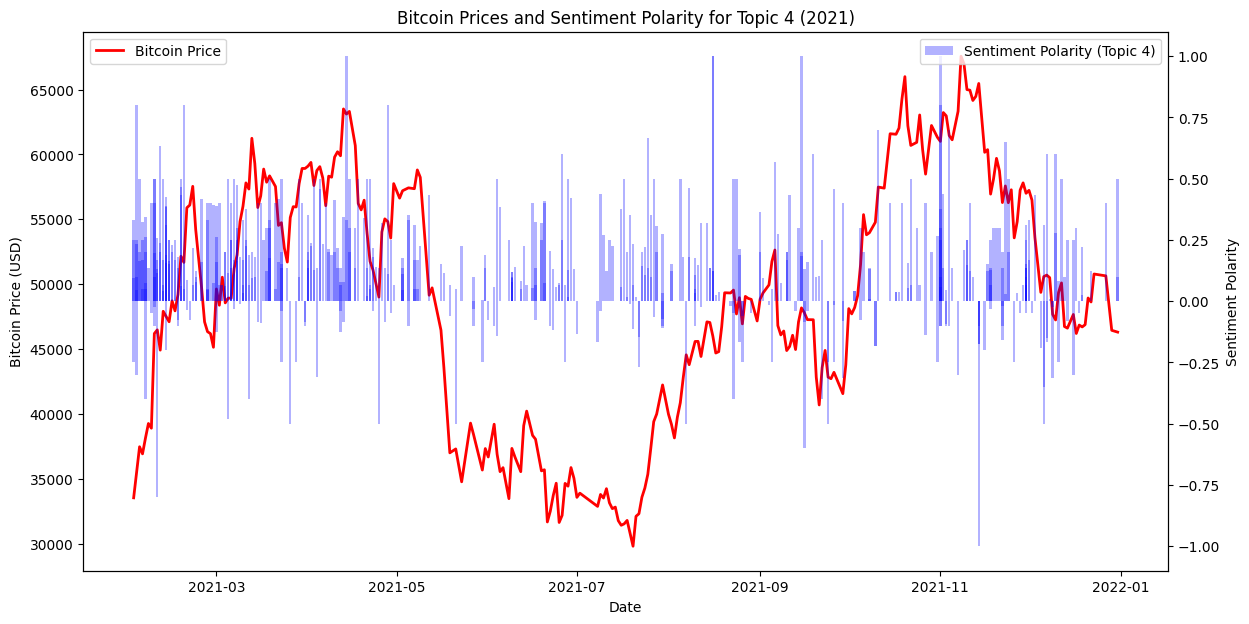

In [ ]:
import matplotlib.pyplot as plt


merged_data_2021 = merged_data[(merged_data['created_at'] >= '2021-01-01') & (merged_data['created_at'] < '2022-01-01')]
topic_4_data_2021 = merged_data_2021[merged_data_2021['topic'] == 4]


plt.figure(figsize=(14, 7))

# Create line plot for Bitcoin prices
plt.plot(topic_4_data_2021['created_at'], topic_4_data_2021['Close'], color='red', label='Bitcoin Price', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Prices and Sentiment Polarity for Topic 4 (2021)')
plt.legend(loc='upper left')

# Create secondary y-axis for sentiment polarity as a bar chart
ax2 = plt.twinx()
ax2.bar(topic_4_data_2021['created_at'], topic_4_data_2021['polarity'], color='blue', label='Sentiment Polarity (Topic 4)', alpha=0.3)
ax2.set_ylabel('Sentiment Polarity')
ax2.legend(loc='upper right')

plt.show()


In [ ]:
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
merged_data['sentiment_score'] = merged_data['sentiment'].map(sentiment_mapping)

In [ ]:
print(merged_data.head())

                                          clean_text created_at sentiment  \
0  privacy human right learn make bitcoin transac... 2021-02-01  positive   
1  overall btc trading volume increased average t... 2021-02-01  negative   
2  average return distribution btc skews slightly... 2021-02-01  positive   
3  latest repo research hub gdacapital talk secur... 2021-02-01  positive   
4  sent stcomfyrz35zjf givedirectly great work di... 2021-02-01  positive   

                                            pos_tags  topic          Open  \
0  [(privacy, NN), (human, JJ), (right, NN), (lea...      4  33114.578125   
1  [(overall, JJ), (btc, NN), (trading, NN), (vol...      3  33114.578125   
2  [(average, JJ), (return, NN), (distribution, N...      3  33114.578125   
3  [(latest, JJS), (repo, NN), (research, NN), (h...      4  33114.578125   
4  [(sent, NN), (stcomfyrz35zjf, NN), (givedirect...      4  33114.578125   

           High           Low         Close     Adj Close       Volume  \


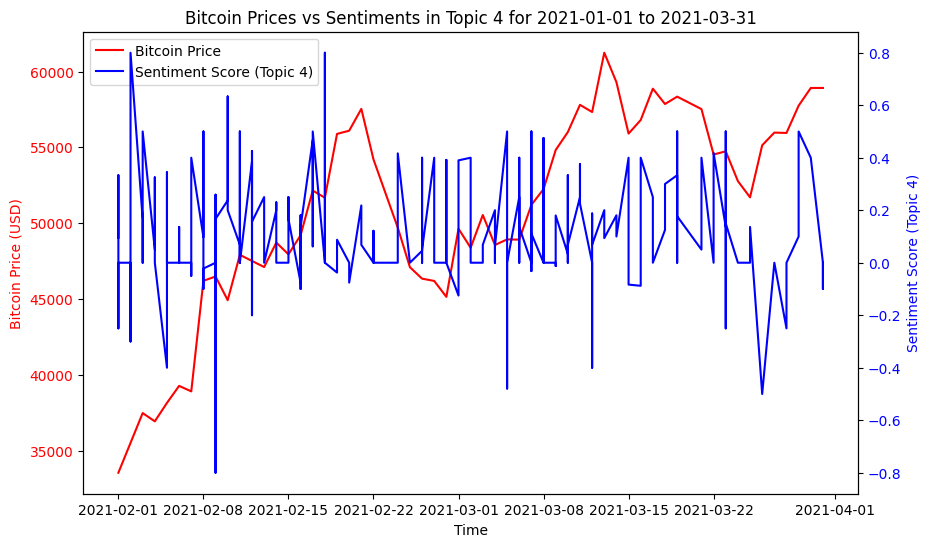

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for the three-month period
start_date = '2021-01-01'
end_date = '2021-03-31'

# Filter data for the three-month period
three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

# Filter data for topic 4
topic_4_three_month = three_month_data[three_month_data['topic'] == 4]

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Bitcoin prices on primary y-axis
ax1.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bitcoin Price (USD)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create secondary y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 4)')
ax2.set_ylabel('Sentiment Score (Topic 4)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

# Set title
plt.title(f'Bitcoin Prices vs Sentiments in Topic 4 for {start_date} to {end_date}')

# Show plot
plt.show()


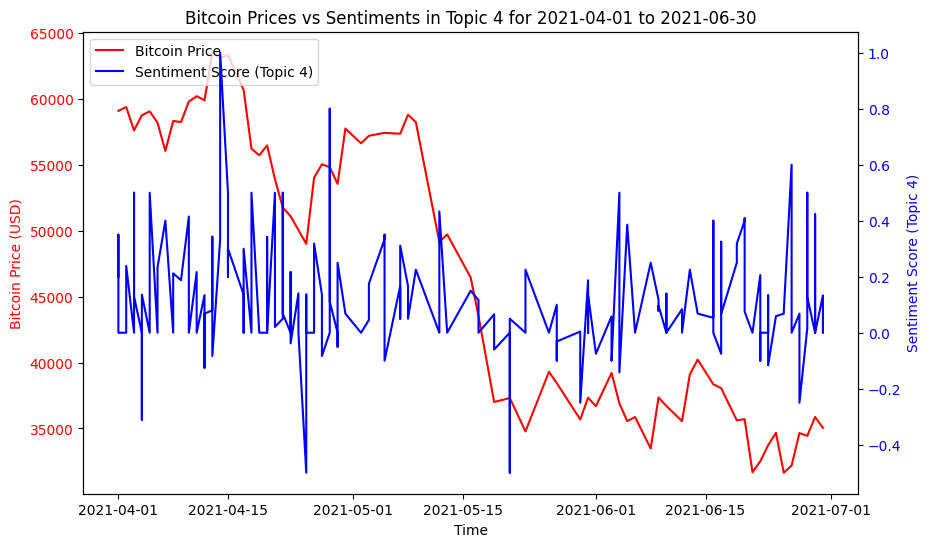

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for the next three-month period
start_date = '2021-04-01'
end_date = '2021-06-30'

# Filter data for the next three-month period
next_three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

# Filter data for topic 4
topic_4_next_three_month = next_three_month_data[next_three_month_data['topic'] == 4]

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Bitcoin prices on primary y-axis
ax1.plot(topic_4_next_three_month['created_at'], topic_4_next_three_month['Close'], color='red', label='Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bitcoin Price (USD)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create secondary y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(topic_4_next_three_month['created_at'], topic_4_next_three_month['polarity'], color='blue', label='Sentiment Score (Topic 4)')
ax2.set_ylabel('Sentiment Score (Topic 4)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

# Set title
plt.title(f'Bitcoin Prices vs Sentiments in Topic 4 for {start_date} to {end_date}')

# Show plot
plt.show()


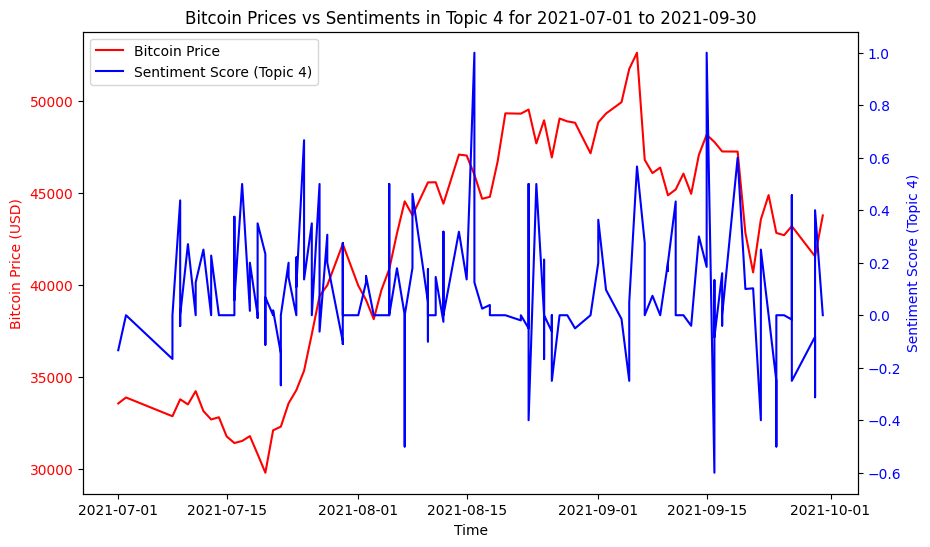

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for the next three-month period
start_date = '2021-07-01'
end_date = '2021-09-30'

# Filter data for the next three-month period
next_three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

# Filter data for topic 4
topic_4_next_three_month = next_three_month_data[next_three_month_data['topic'] == 4]

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Bitcoin prices on primary y-axis
ax1.plot(topic_4_next_three_month['created_at'], topic_4_next_three_month['Close'], color='red', label='Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bitcoin Price (USD)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create secondary y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(topic_4_next_three_month['created_at'], topic_4_next_three_month['polarity'], color='blue', label='Sentiment Score (Topic 4)')
ax2.set_ylabel('Sentiment Score (Topic 4)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

# Set title
plt.title(f'Bitcoin Prices vs Sentiments in Topic 4 for {start_date} to {end_date}')

# Show plot
plt.show()


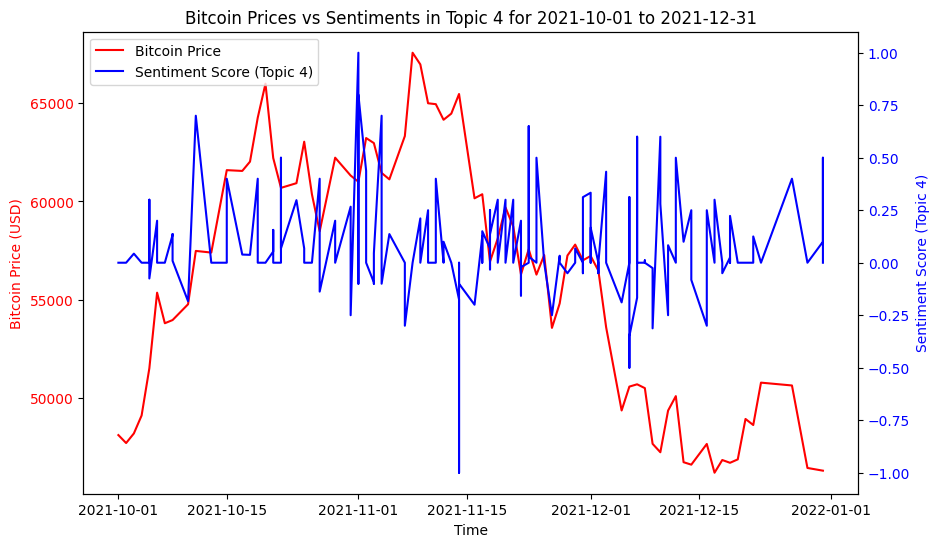

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for the next three-month period
start_date = '2021-10-01'
end_date = '2021-12-31'

# Filter data for the next three-month period
next_three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

# Filter data for topic 4
topic_4_next_three_month = next_three_month_data[next_three_month_data['topic'] == 4]

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Bitcoin prices on primary y-axis
ax1.plot(topic_4_next_three_month['created_at'], topic_4_next_three_month['Close'], color='red', label='Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bitcoin Price (USD)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create secondary y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(topic_4_next_three_month['created_at'], topic_4_next_three_month['polarity'], color='blue', label='Sentiment Score (Topic 4)')
ax2.set_ylabel('Sentiment Score (Topic 4)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

# Set title
plt.title(f'Bitcoin Prices vs Sentiments in Topic 4 for {start_date} to {end_date}')

# Show plot
plt.show()


# **2021**

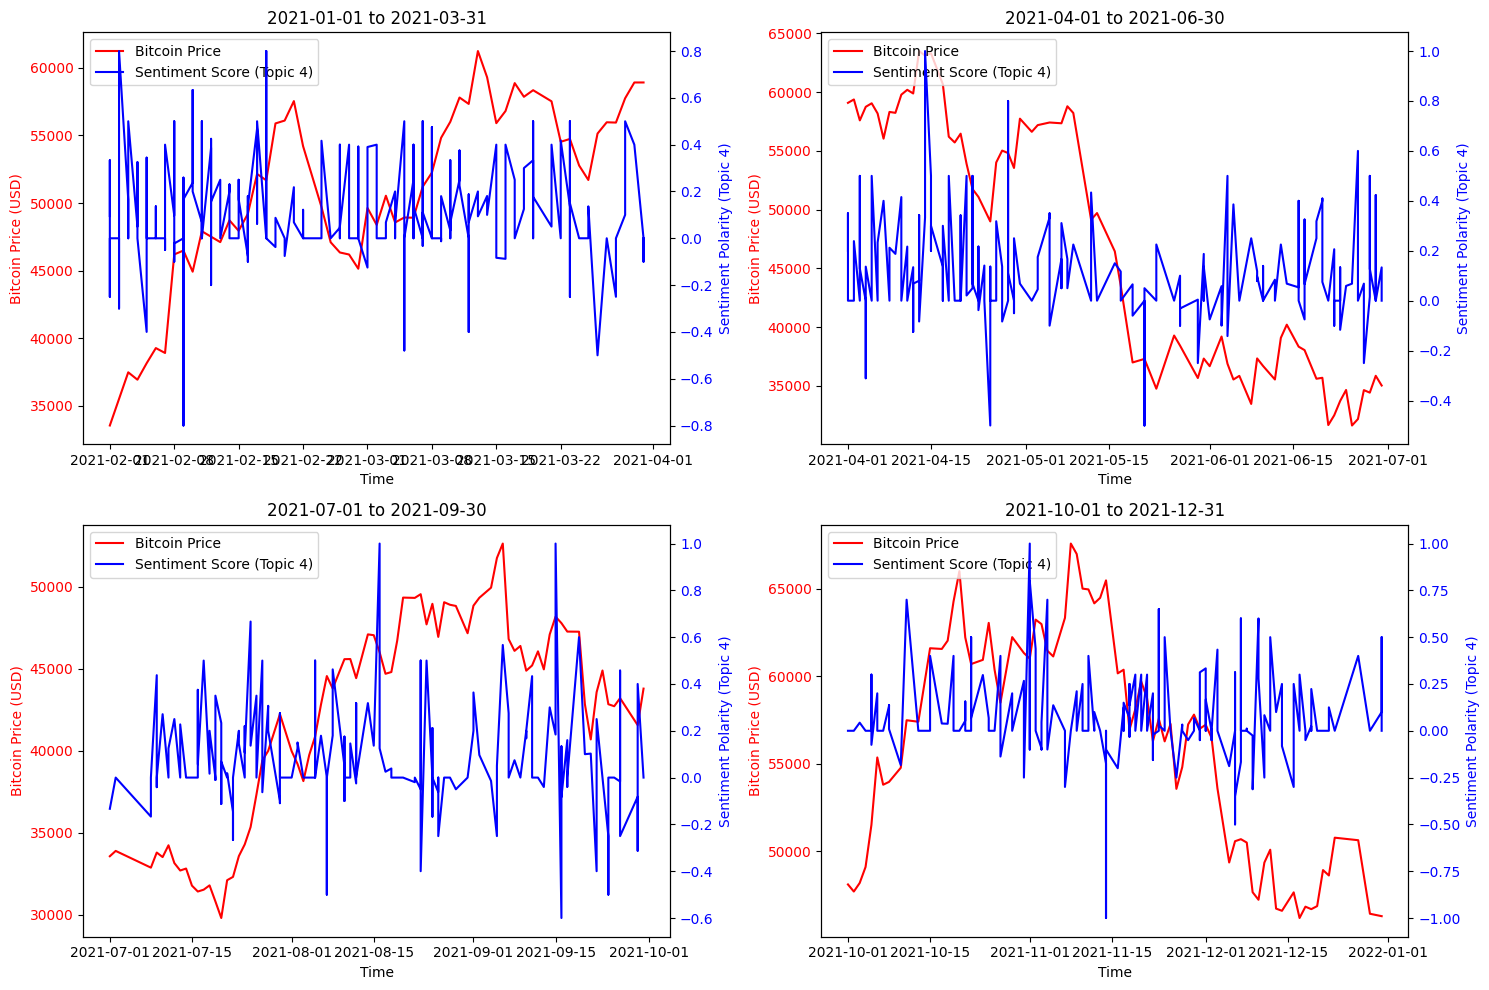

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2021
periods_2021 = [
    ('2021-01-01', '2021-03-31'),
    ('2021-04-01', '2021-06-30'),
    ('2021-07-01', '2021-09-30'),
    ('2021-10-01', '2021-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2021):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 4]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 4
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 4)')
    ax2.set_ylabel('Sentiment Polarity (Topic 4)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# **2022**

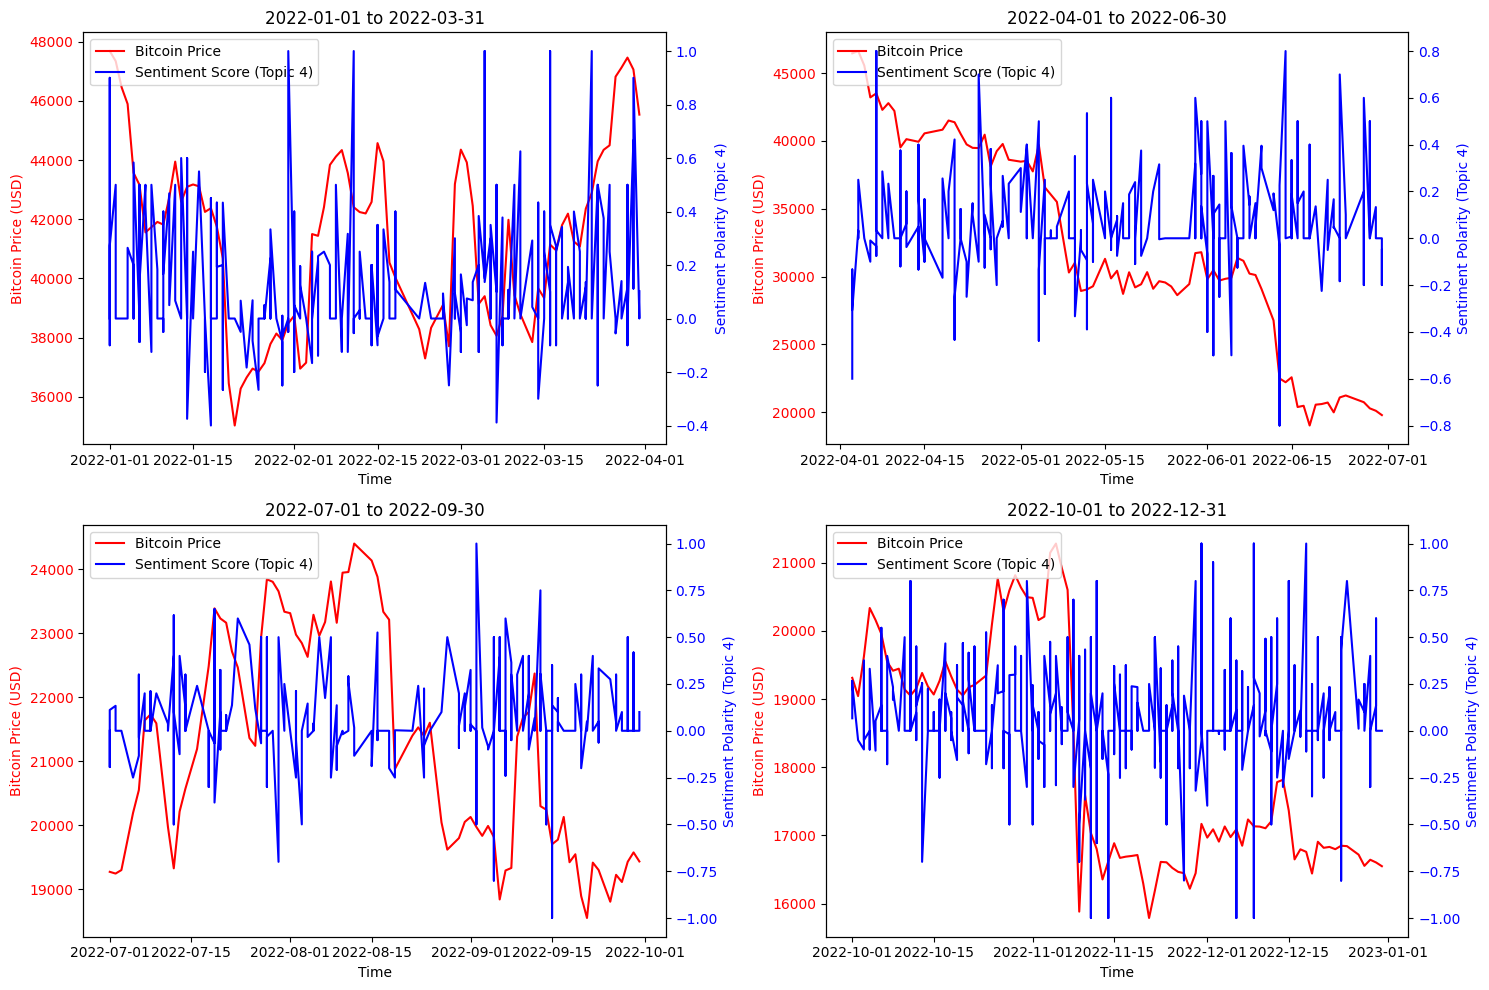

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2022
periods_2022 = [
    ('2022-01-01', '2022-03-31'),
    ('2022-04-01', '2022-06-30'),
    ('2022-07-01', '2022-09-30'),
    ('2022-10-01', '2022-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2022):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 4]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 4
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 4)')
    ax2.set_ylabel('Sentiment Polarity (Topic 4)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# **2023**

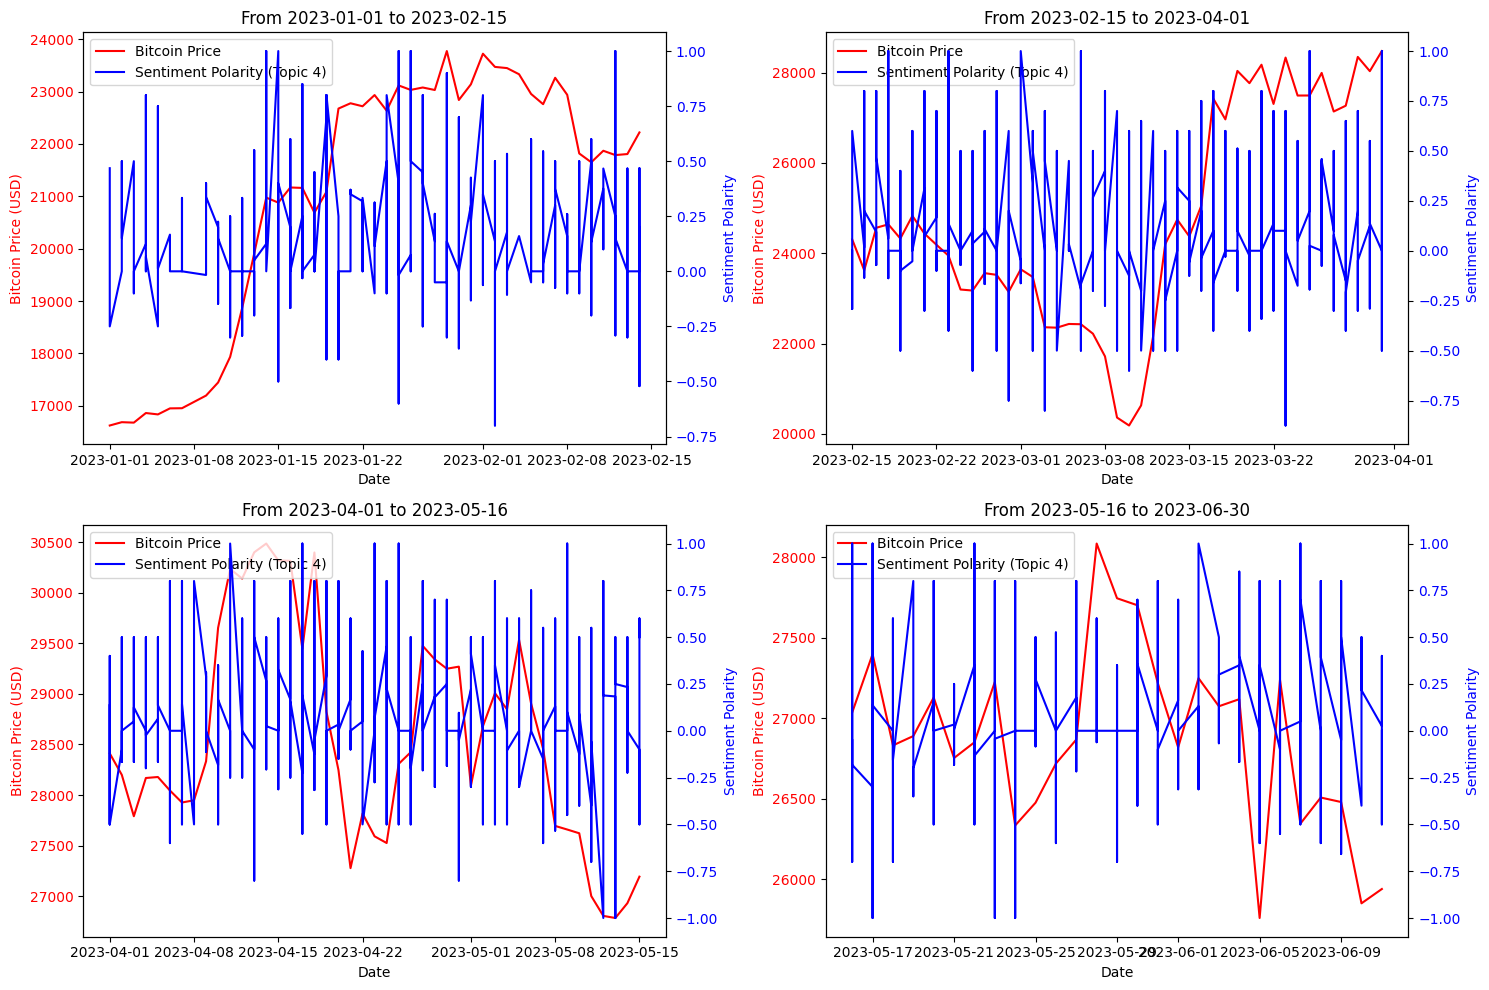

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd  # Assuming merged_data is a DataFrame

# Define the start date and calculate end dates for each interval
start_date = pd.to_datetime('2023-01-01')
end_dates = [start_date + pd.DateOffset(days=45*i) for i in range(1, 5)]

# Define periods
periods_2023 = [(start_date + pd.DateOffset(days=45*(i-1)), end_dates[i-1]) for i in range(1, 5)]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each period
for i, (start, end) in enumerate(periods_2023):
    # Filter data for the period
    period_data = merged_data[(merged_data['created_at'] >= start) & (merged_data['created_at'] < end)]

    # Filter data for topic 4
    topic_4_data = period_data[period_data['topic'] == 4]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment polarity for topic 4
    ax = axs[row, col]
    ax.plot(topic_4_data['created_at'], topic_4_data['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment polarity
    ax2 = ax.twinx()
    ax2.plot(topic_4_data['created_at'], topic_4_data['polarity'], color='blue', label='Sentiment Polarity (Topic 4)')
    ax2.set_ylabel('Sentiment Polarity', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title to include the start and end date of the period
    ax.set_title(f'From {start.date()} to {end.date()}')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


**Further analysis - for other topics**

Topic 0 (2021)

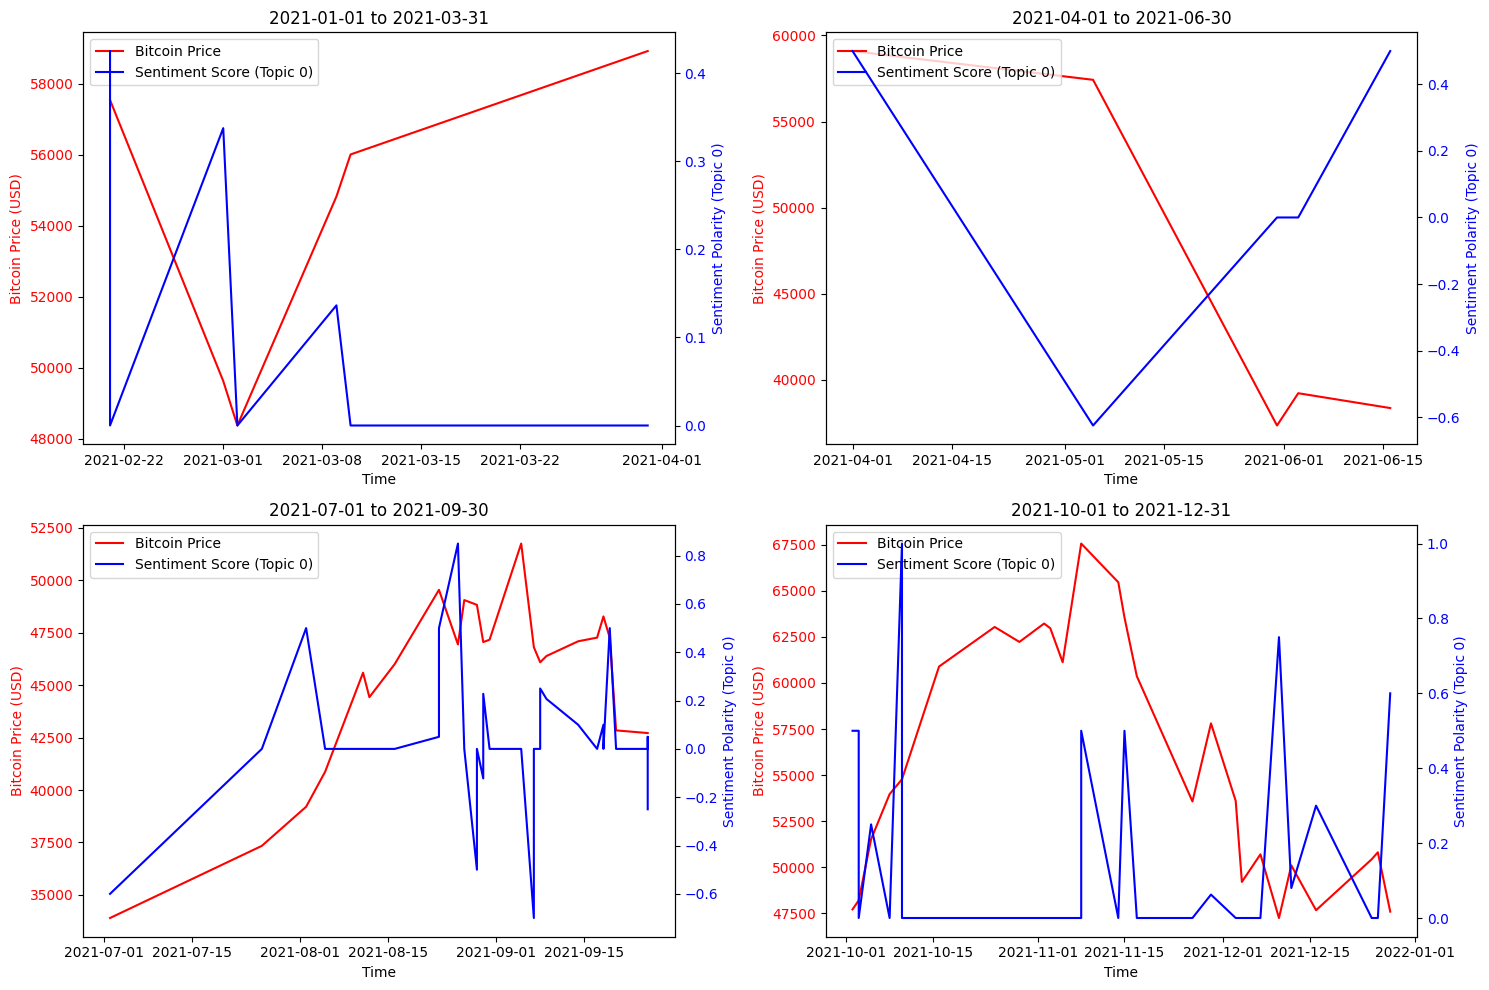

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2021
periods_2021 = [
    ('2021-01-01', '2021-03-31'),
    ('2021-04-01', '2021-06-30'),
    ('2021-07-01', '2021-09-30'),
    ('2021-10-01', '2021-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2021):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 0]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 0
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 0)')
    ax2.set_ylabel('Sentiment Polarity (Topic 0)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 0 (2022)

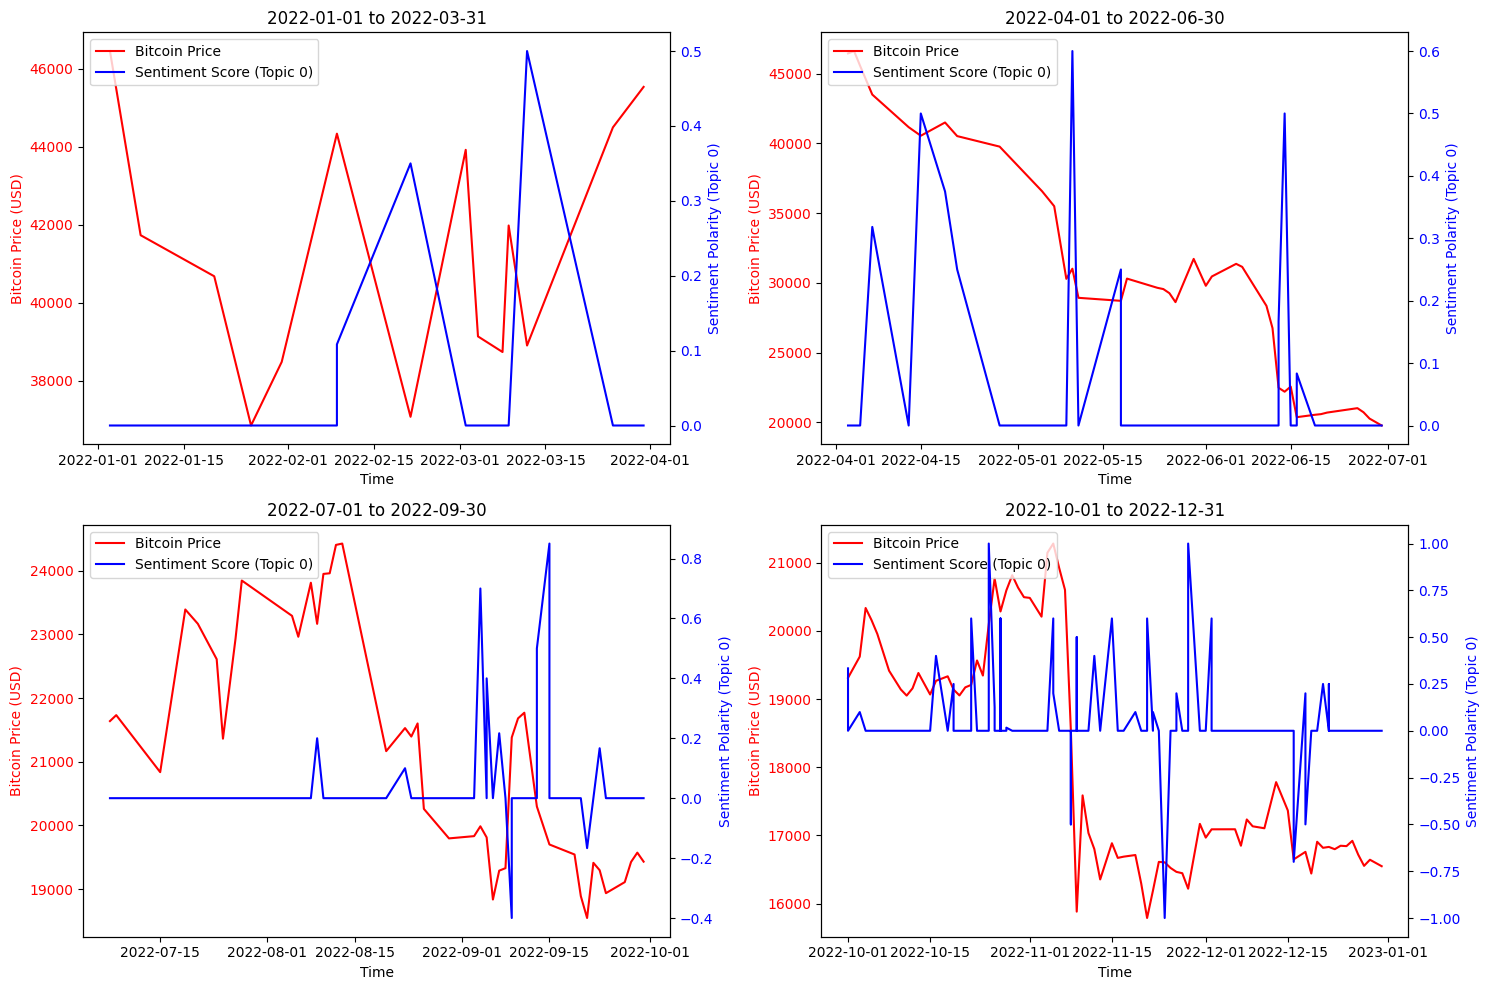

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2022
periods_2022 = [
    ('2022-01-01', '2022-03-31'),
    ('2022-04-01', '2022-06-30'),
    ('2022-07-01', '2022-09-30'),
    ('2022-10-01', '2022-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2022):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 0]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 4
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 0)')
    ax2.set_ylabel('Sentiment Polarity (Topic 0)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 0 (2023)

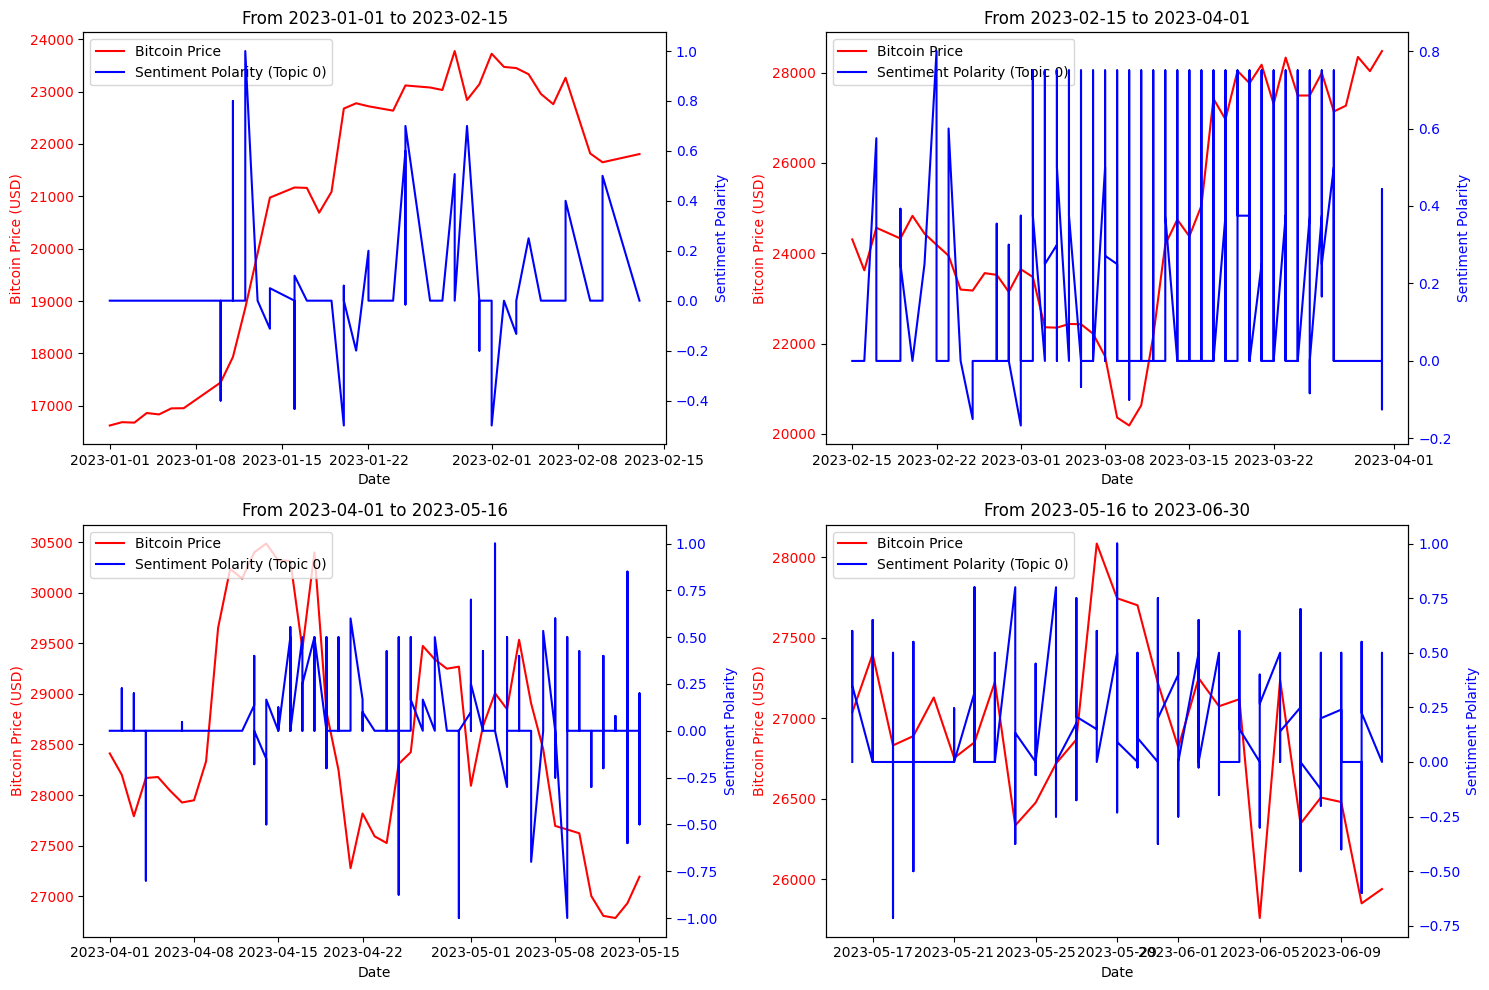

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd  # Assuming merged_data is a DataFrame

# Define the start date and calculate end dates for each interval
start_date = pd.to_datetime('2023-01-01')
end_dates = [start_date + pd.DateOffset(days=45*i) for i in range(1, 5)]

# Define periods with the calculated end dates, ensuring coverage until 2023-06-30
periods_2023 = [(start_date + pd.DateOffset(days=45*(i-1)), end_dates[i-1]) for i in range(1, 5)]

# Adjust the last period to end exactly on 2023-06-30
periods_2023[-1] = (periods_2023[-2][1], pd.to_datetime('2023-06-30'))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each period
for i, (start, end) in enumerate(periods_2023):
    # Filter data for the period
    period_data = merged_data[(merged_data['created_at'] >= start) & (merged_data['created_at'] < end)]

    # Filter data for topic 0
    topic_data = period_data[period_data['topic'] == 0]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment polarity for topic 0
    ax = axs[row, col]
    ax.plot(topic_data['created_at'], topic_data['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment polarity
    ax2 = ax.twinx()
    ax2.plot(topic_data['created_at'], topic_data['polarity'], color='blue', label='Sentiment Polarity (Topic 0)')
    ax2.set_ylabel('Sentiment Polarity', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title to include the start and end date of the period
    ax.set_title(f'From {start.date()} to {end.date()}')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


Topic 1 (2021)

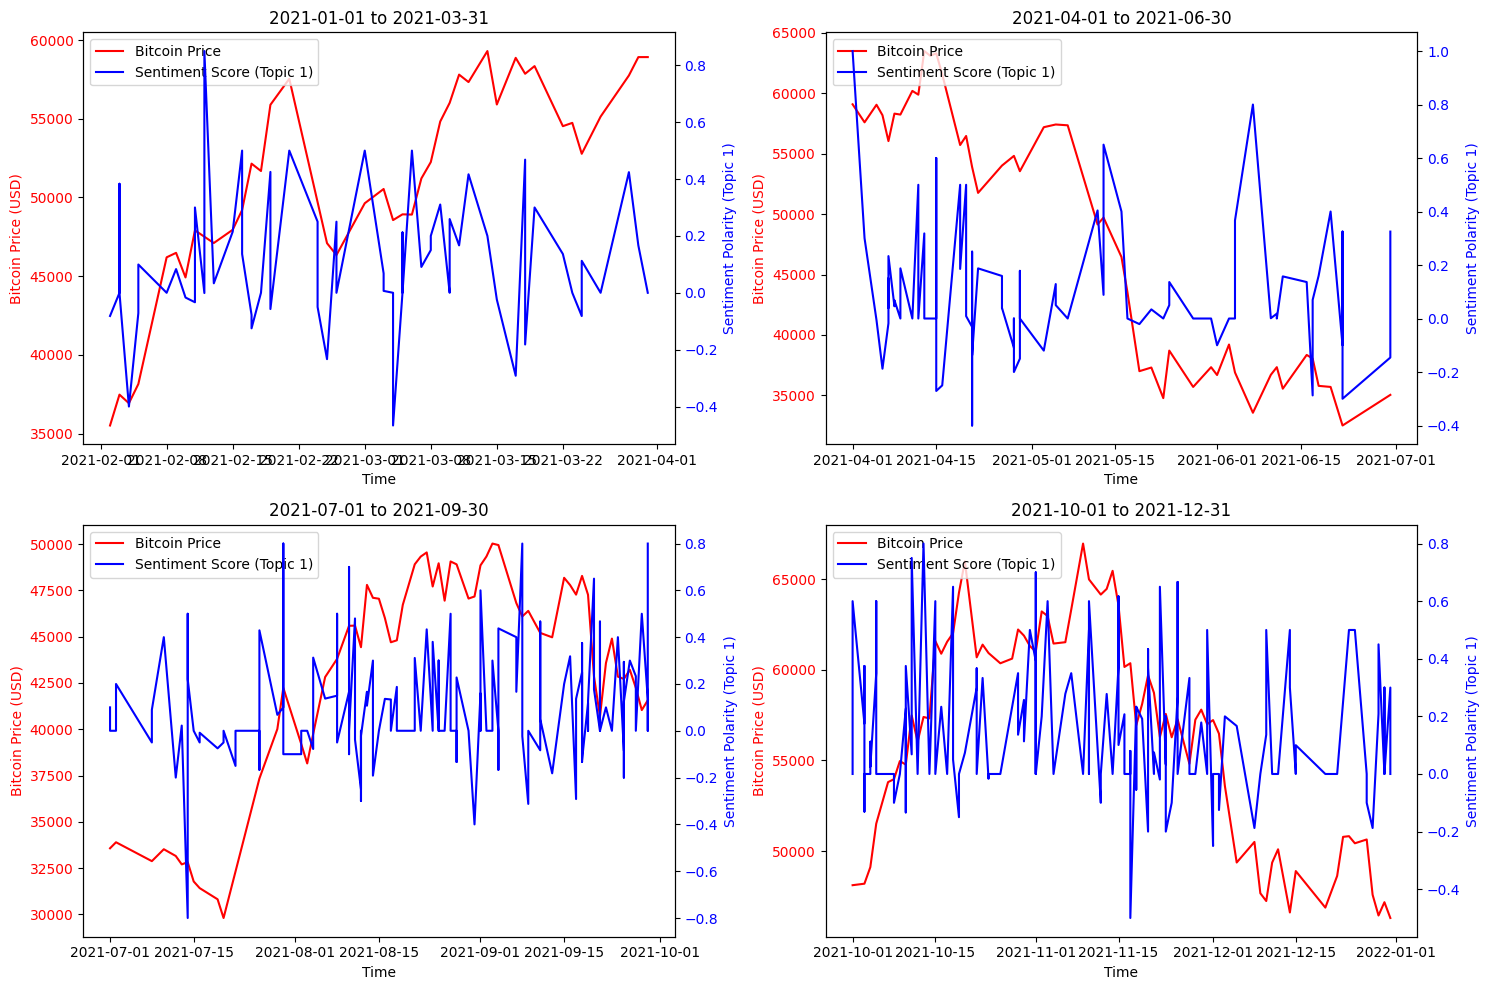

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2021
periods_2021 = [
    ('2021-01-01', '2021-03-31'),
    ('2021-04-01', '2021-06-30'),
    ('2021-07-01', '2021-09-30'),
    ('2021-10-01', '2021-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2021):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 1]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 0
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 1)')
    ax2.set_ylabel('Sentiment Polarity (Topic 1)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 1 (2022)

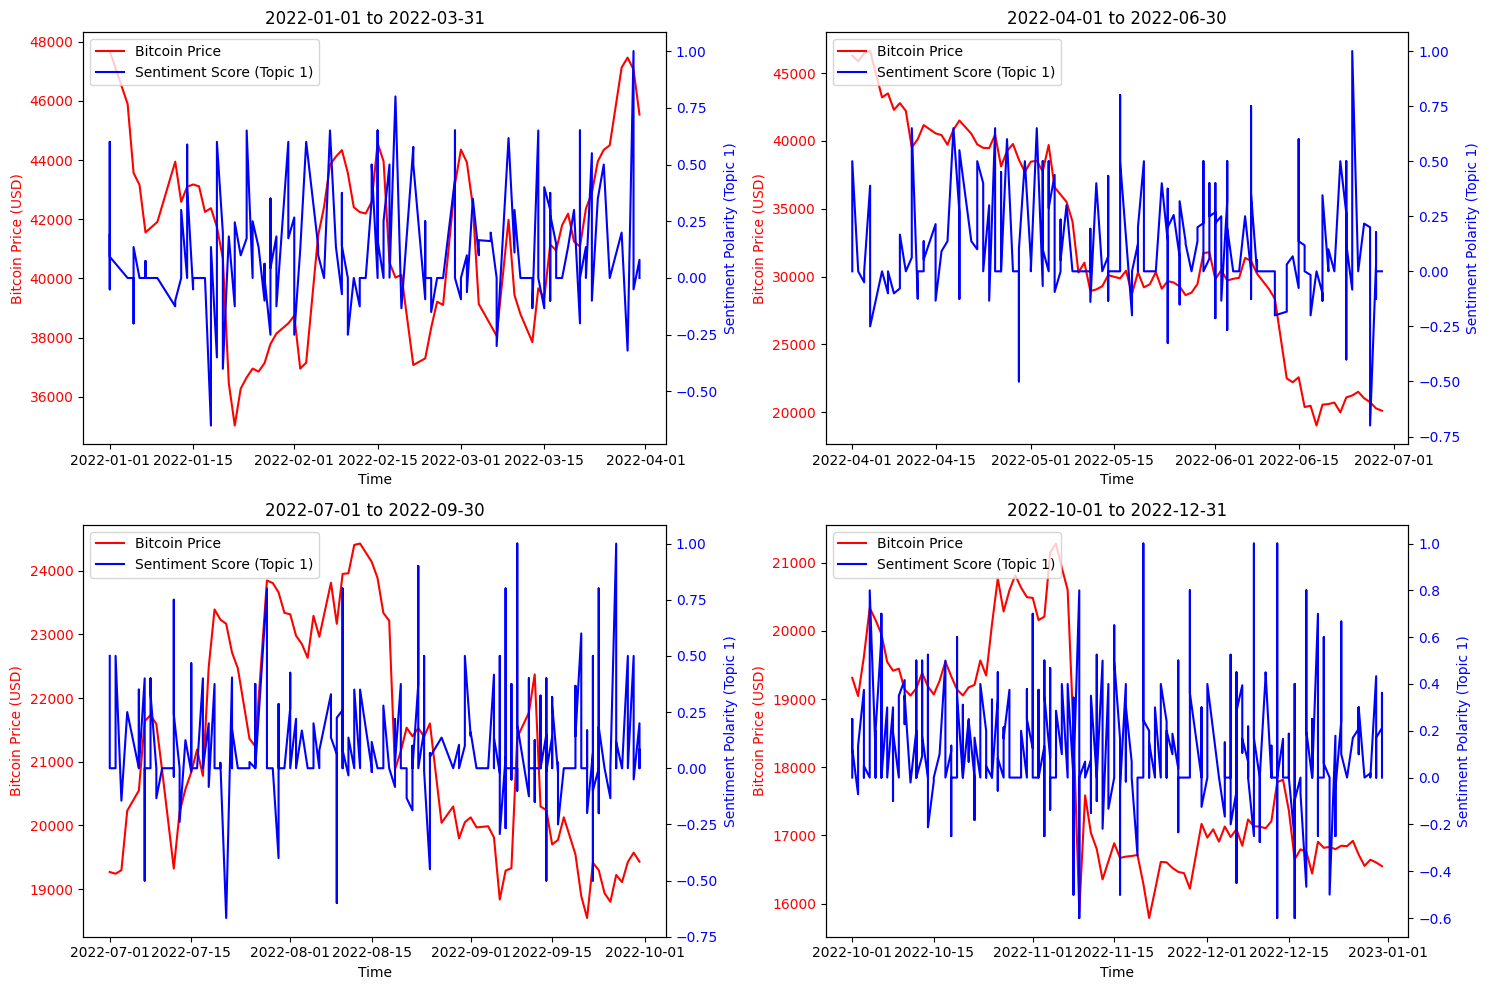

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2022
periods_2022 = [
    ('2022-01-01', '2022-03-31'),
    ('2022-04-01', '2022-06-30'),
    ('2022-07-01', '2022-09-30'),
    ('2022-10-01', '2022-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2022):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 1]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 4
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 1)')
    ax2.set_ylabel('Sentiment Polarity (Topic 1)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 1 (2023)

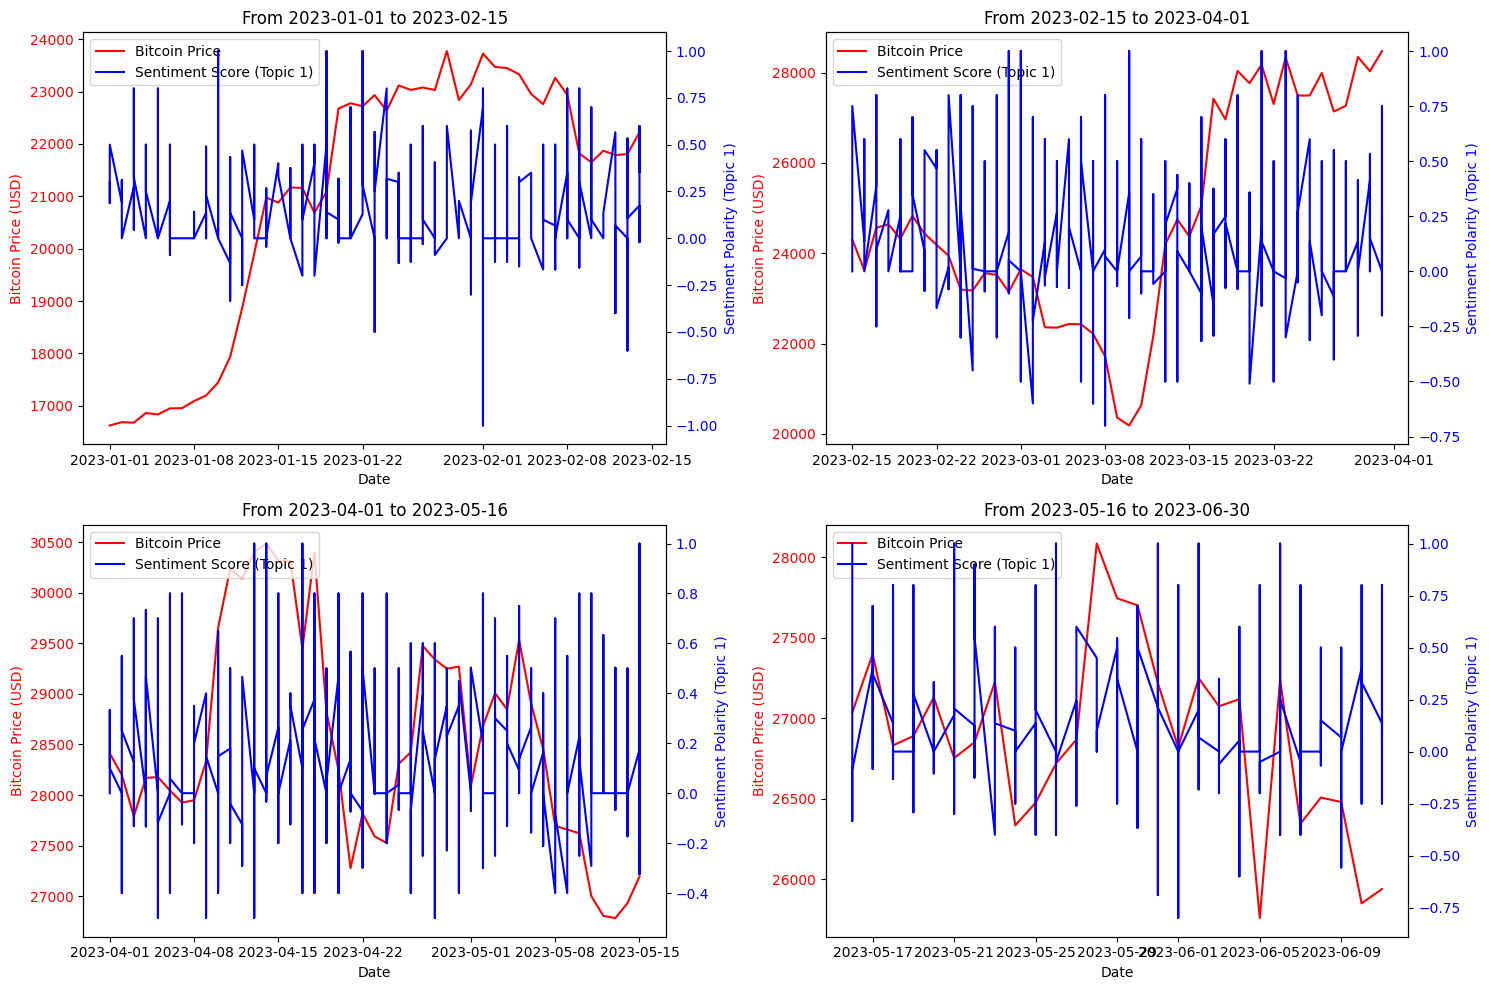

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd  # Assuming merged_data is a DataFrame

# Define the start date and calculate end dates for each interval
start_date = pd.to_datetime('2023-01-01')
end_dates = [start_date + pd.DateOffset(days=45*i) for i in range(1, 5)]

# Define periods with the calculated end dates, ensuring coverage until 2023-06-30
periods_2023 = [(start_date + pd.DateOffset(days=45*(i-1)), end_dates[i-1]) for i in range(1, 5)]

# Adjust the last period to end exactly on 2023-06-30
periods_2023[-1] = (periods_2023[-2][1], pd.to_datetime('2023-06-30'))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each period
for i, (start, end) in enumerate(periods_2023):
    # Filter data for the period
    period_data = merged_data[(merged_data['created_at'] >= start) & (merged_data['created_at'] < end)]

    # Filter data for topic 1
    topic_data = period_data[period_data['topic'] == 1]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 1
    ax = axs[row, col]
    ax.plot(topic_data['created_at'], topic_data['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_data['created_at'], topic_data['polarity'], color='blue', label='Sentiment Score (Topic 1)')
    ax2.set_ylabel('Sentiment Polarity (Topic 1)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title to include the start and end date of the period
    ax.set_title(f'From {start.date()} to {end.date()}')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


Topic 2 (2021)

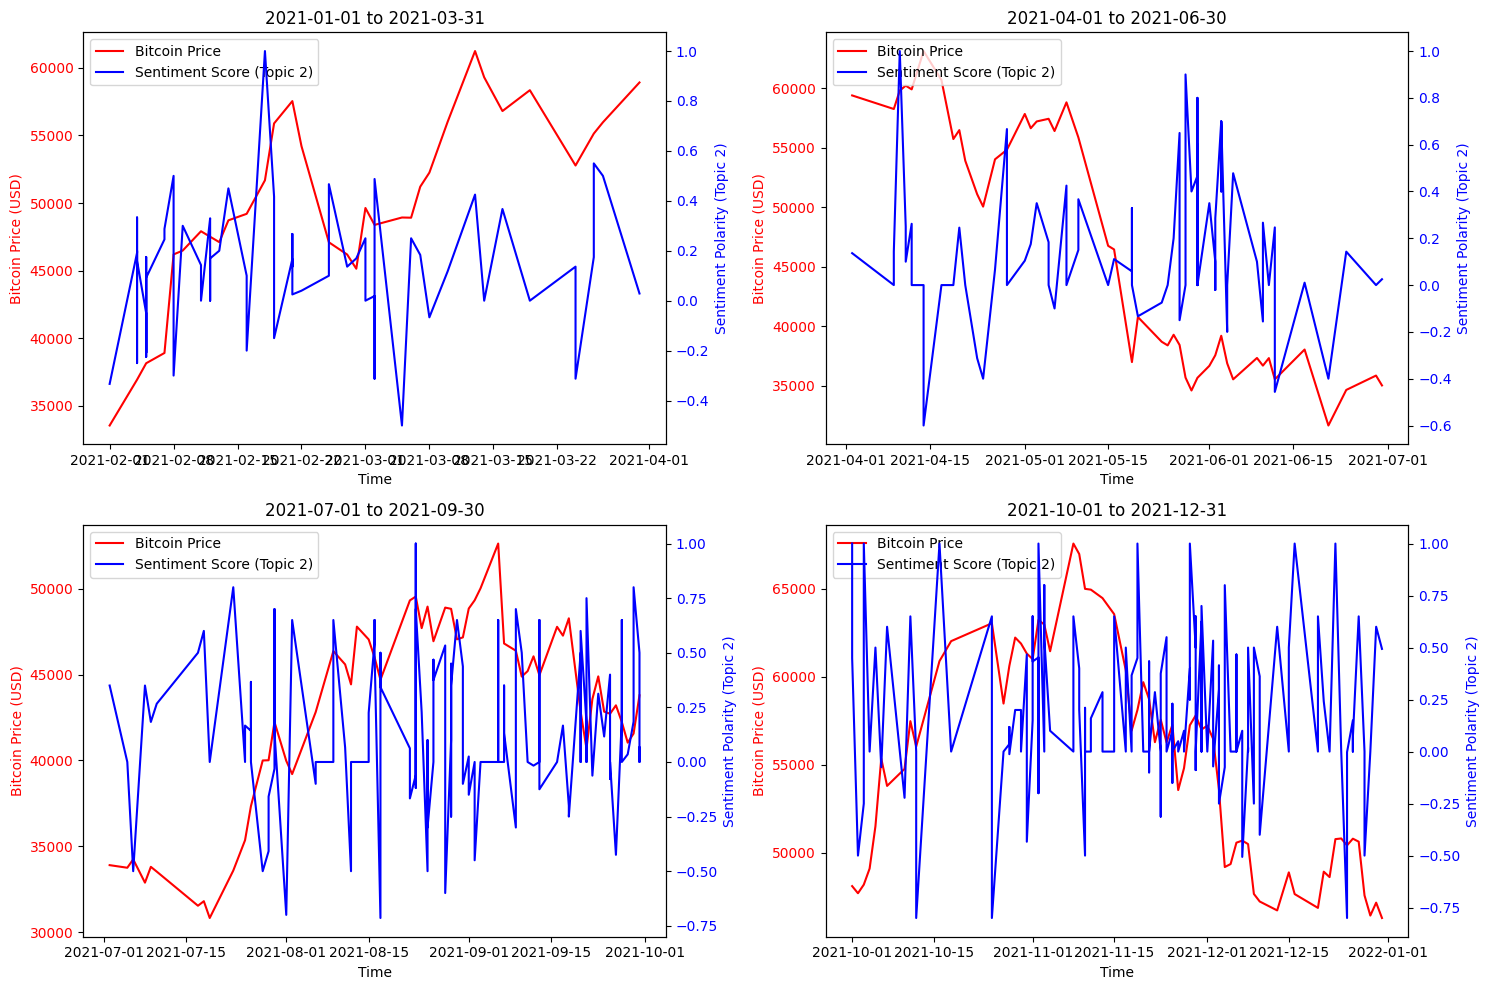

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2021
periods_2021 = [
    ('2021-01-01', '2021-03-31'),
    ('2021-04-01', '2021-06-30'),
    ('2021-07-01', '2021-09-30'),
    ('2021-10-01', '2021-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2021):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 2]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 0
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 2)')
    ax2.set_ylabel('Sentiment Polarity (Topic 2)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 2 (2022)

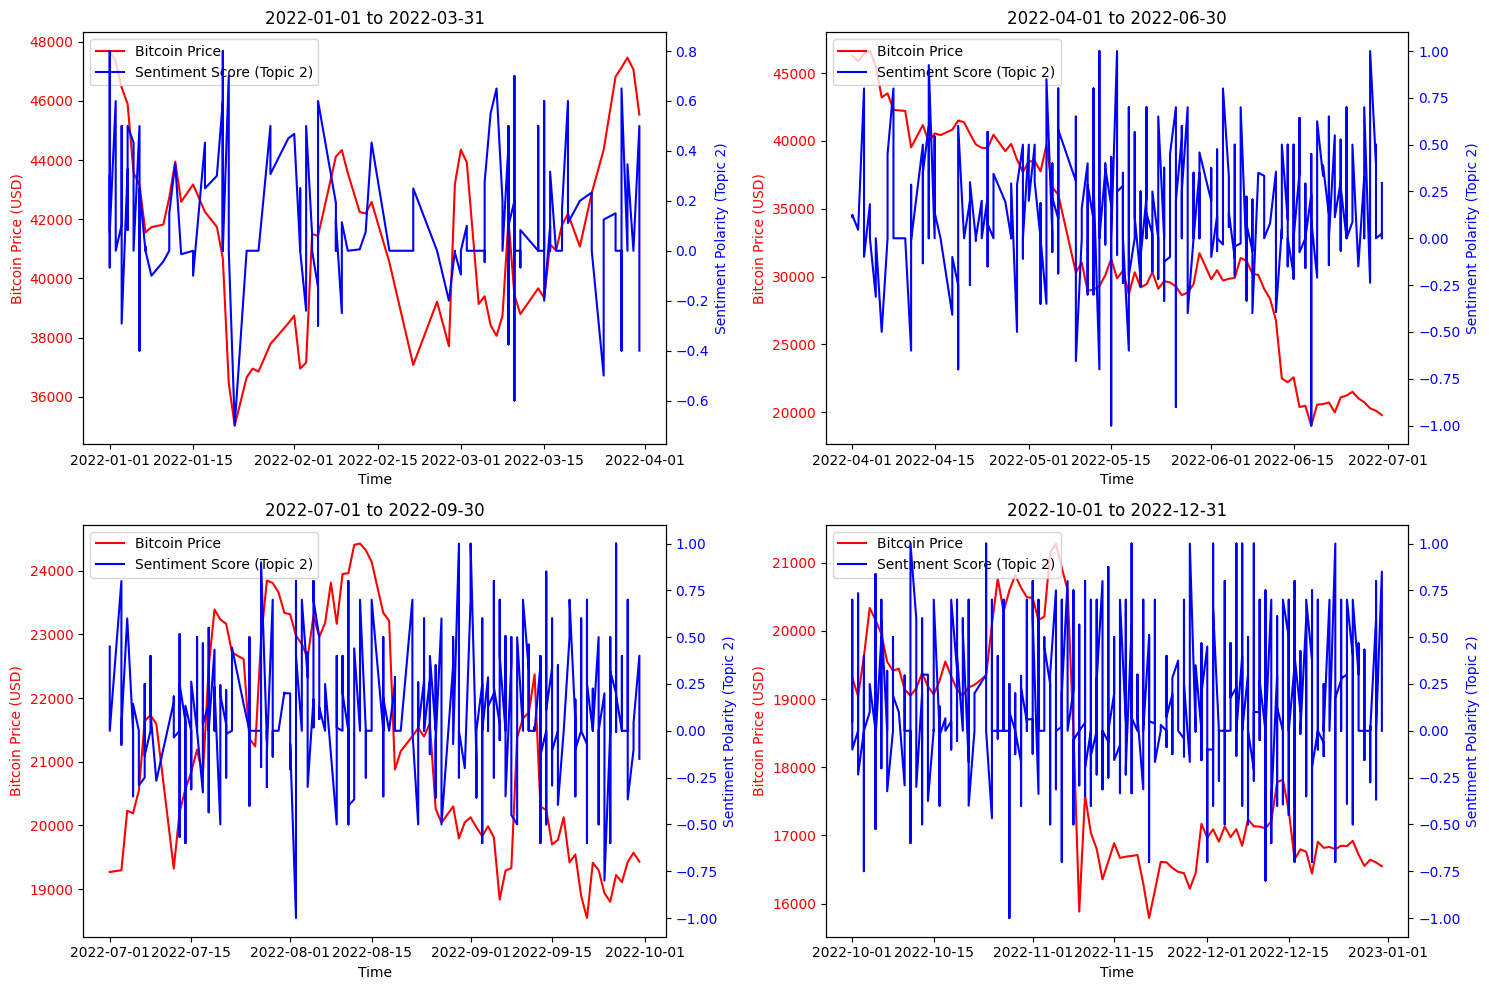

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2022
periods_2022 = [
    ('2022-01-01', '2022-03-31'),
    ('2022-04-01', '2022-06-30'),
    ('2022-07-01', '2022-09-30'),
    ('2022-10-01', '2022-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2022):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 2]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 4
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 2)')
    ax2.set_ylabel('Sentiment Polarity (Topic 2)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 2 (2023)

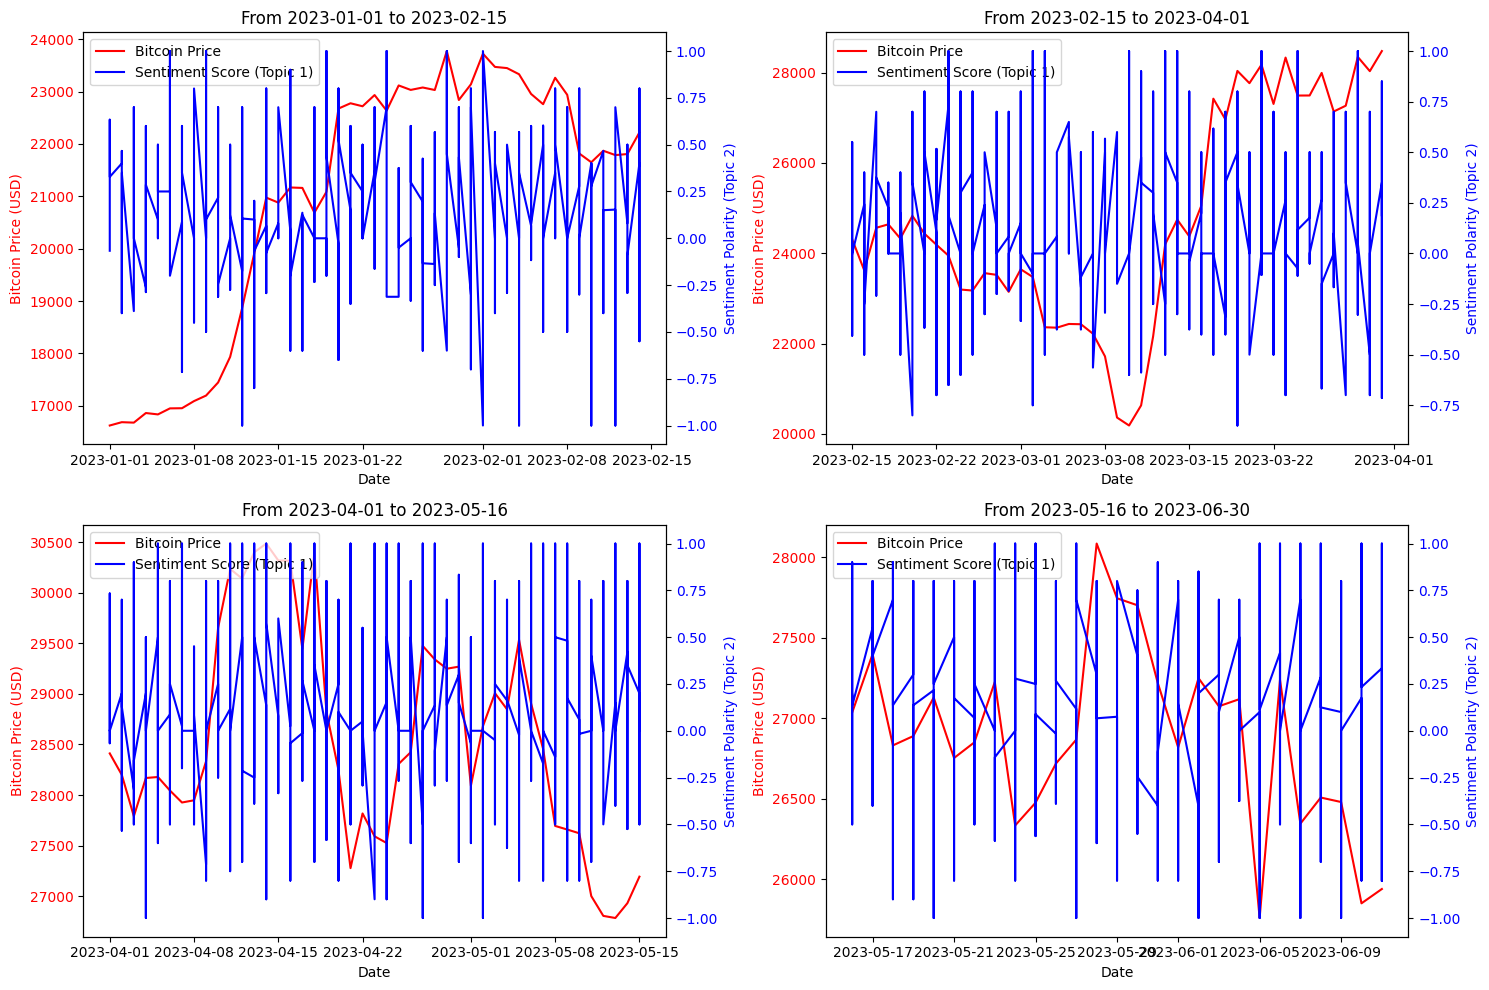

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd  # Assuming merged_data is a DataFrame

# Define the start date and calculate end dates for each interval
start_date = pd.to_datetime('2023-01-01')
end_dates = [start_date + pd.DateOffset(days=45*i) for i in range(1, 5)]

# Define periods with the calculated end dates, ensuring coverage until 2023-06-30
periods_2023 = [(start_date + pd.DateOffset(days=45*(i-1)), end_dates[i-1]) for i in range(1, 5)]

# Adjust the last period to end exactly on 2023-06-30
periods_2023[-1] = (periods_2023[-2][1], pd.to_datetime('2023-06-30'))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each period
for i, (start, end) in enumerate(periods_2023):
    # Filter data for the period
    period_data = merged_data[(merged_data['created_at'] >= start) & (merged_data['created_at'] < end)]

    # Filter data for topic 1
    topic_data = period_data[period_data['topic'] == 2]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 1
    ax = axs[row, col]
    ax.plot(topic_data['created_at'], topic_data['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_data['created_at'], topic_data['polarity'], color='blue', label='Sentiment Score (Topic 1)')
    ax2.set_ylabel('Sentiment Polarity (Topic 2)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title to include the start and end date of the period
    ax.set_title(f'From {start.date()} to {end.date()}')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


Topic 3 (2021)

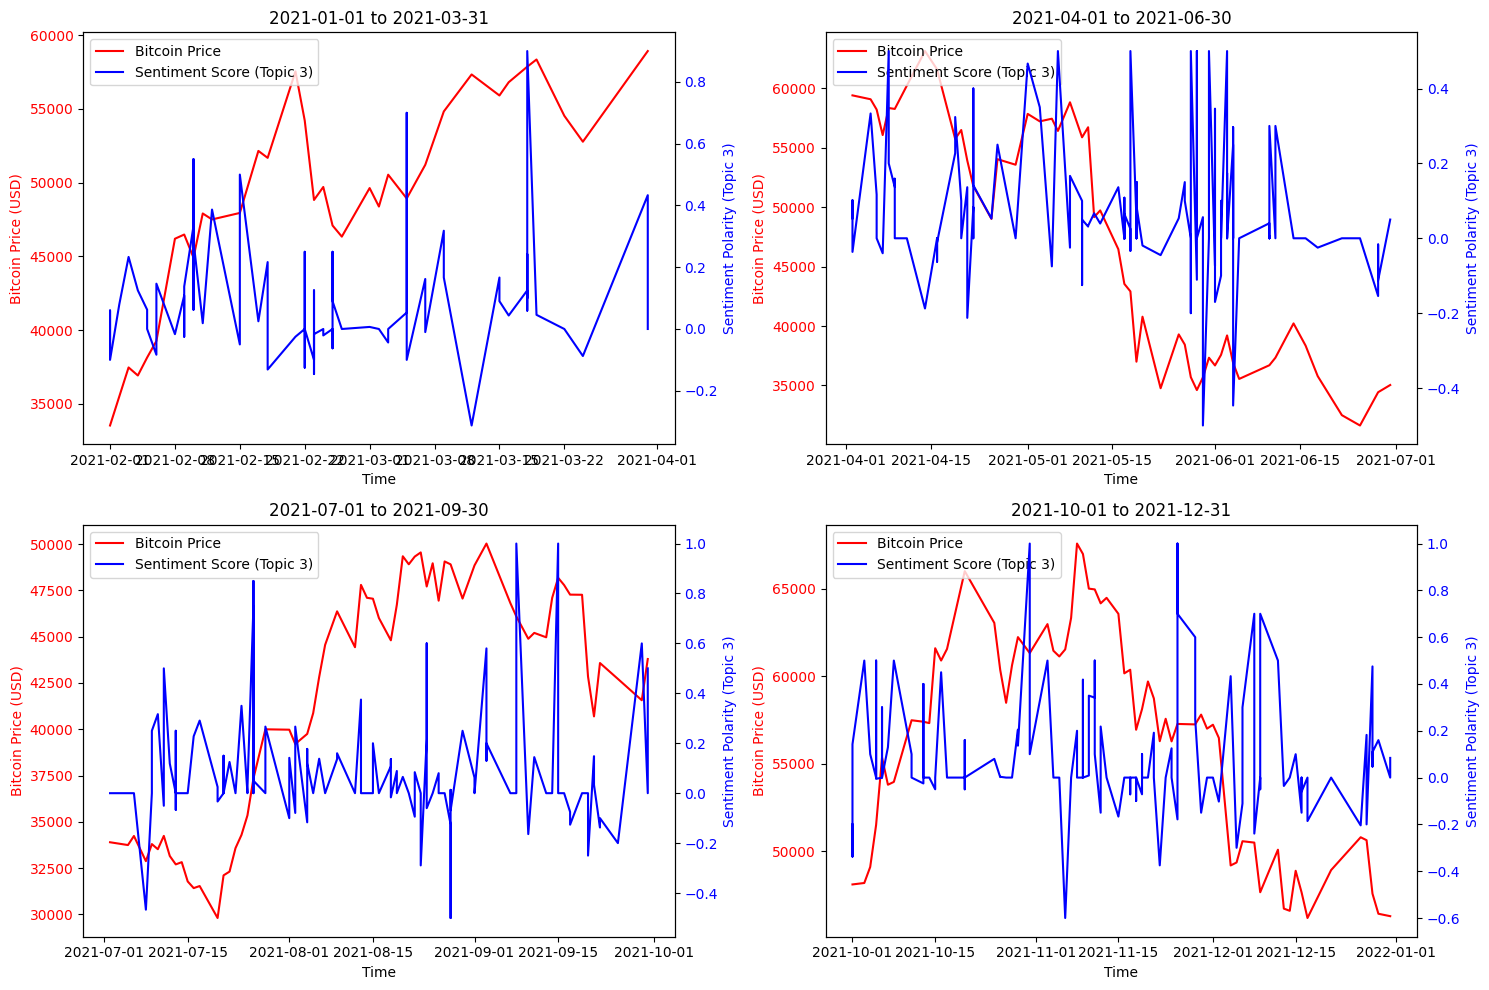

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2021
periods_2021 = [
    ('2021-01-01', '2021-03-31'),
    ('2021-04-01', '2021-06-30'),
    ('2021-07-01', '2021-09-30'),
    ('2021-10-01', '2021-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2021):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 3]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 0
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 3)')
    ax2.set_ylabel('Sentiment Polarity (Topic 3)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 3 (2022)

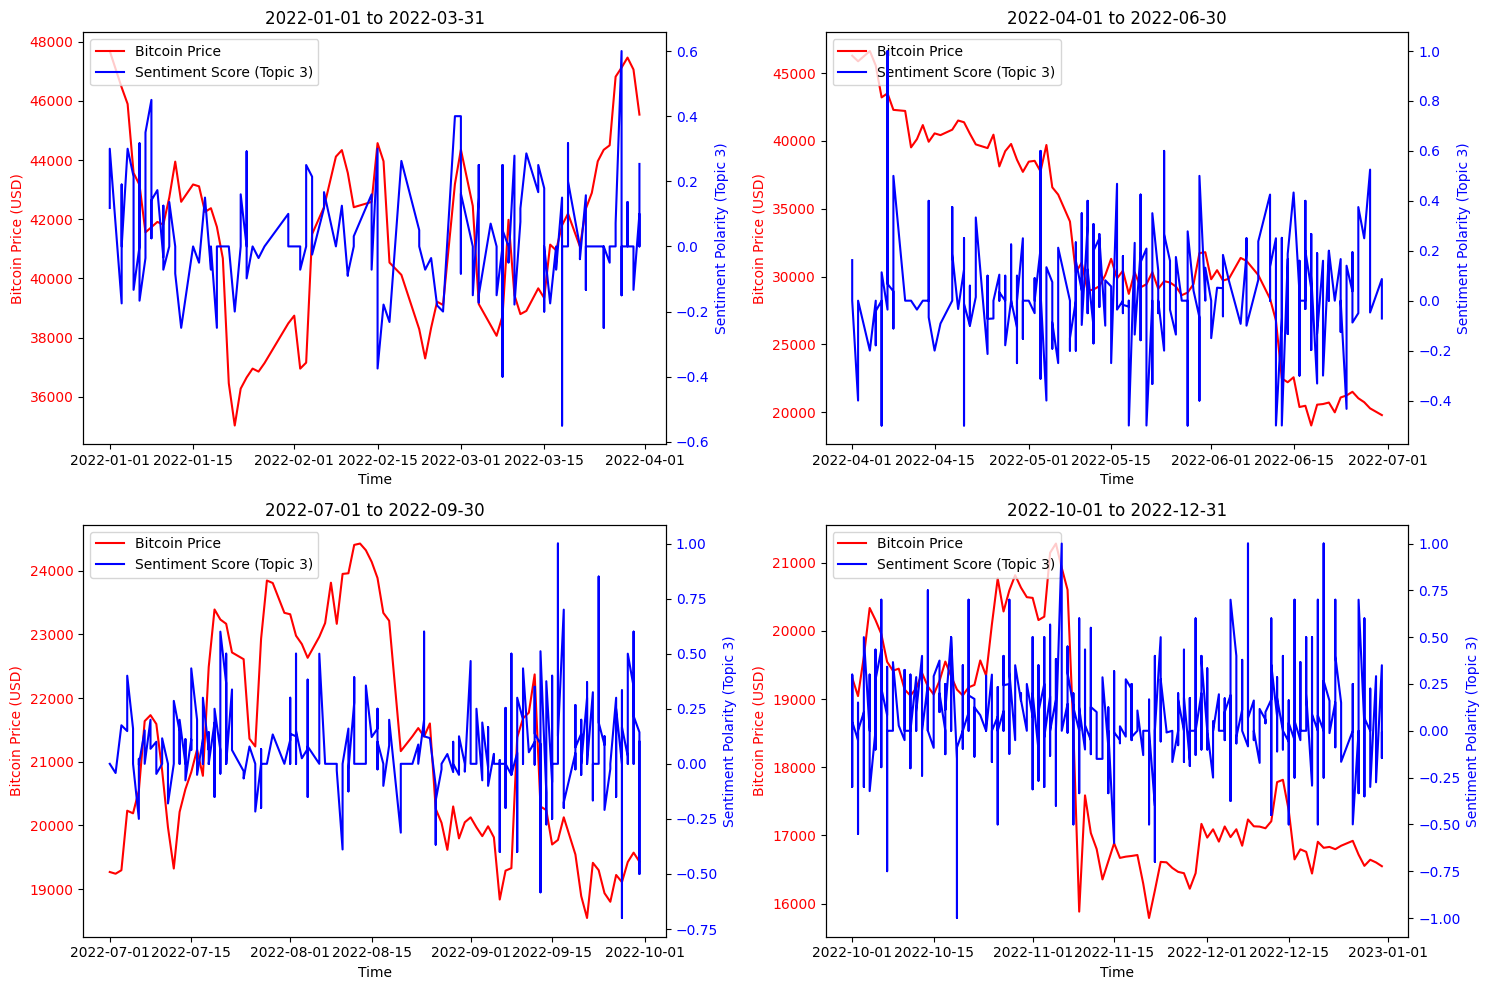

In [ ]:
import matplotlib.pyplot as plt

# Define the start and end dates for each three-month period in 2022
periods_2022 = [
    ('2022-01-01', '2022-03-31'),
    ('2022-04-01', '2022-06-30'),
    ('2022-07-01', '2022-09-30'),
    ('2022-10-01', '2022-12-31')
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each three-month period
for i, (start_date, end_date) in enumerate(periods_2022):
    # Filter data for the three-month period
    three_month_data = merged_data[(merged_data['created_at'] >= start_date) & (merged_data['created_at'] <= end_date)]

    # Filter data for topic 4
    topic_4_three_month = three_month_data[three_month_data['topic'] == 3]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 4
    ax = axs[row, col]
    ax.plot(topic_4_three_month['created_at'], topic_4_three_month['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Time')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_4_three_month['created_at'], topic_4_three_month['polarity'], color='blue', label='Sentiment Score (Topic 3)')
    ax2.set_ylabel('Sentiment Polarity (Topic 3)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title
    ax.set_title(f'{start_date} to {end_date}')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Topic 3 (2023)

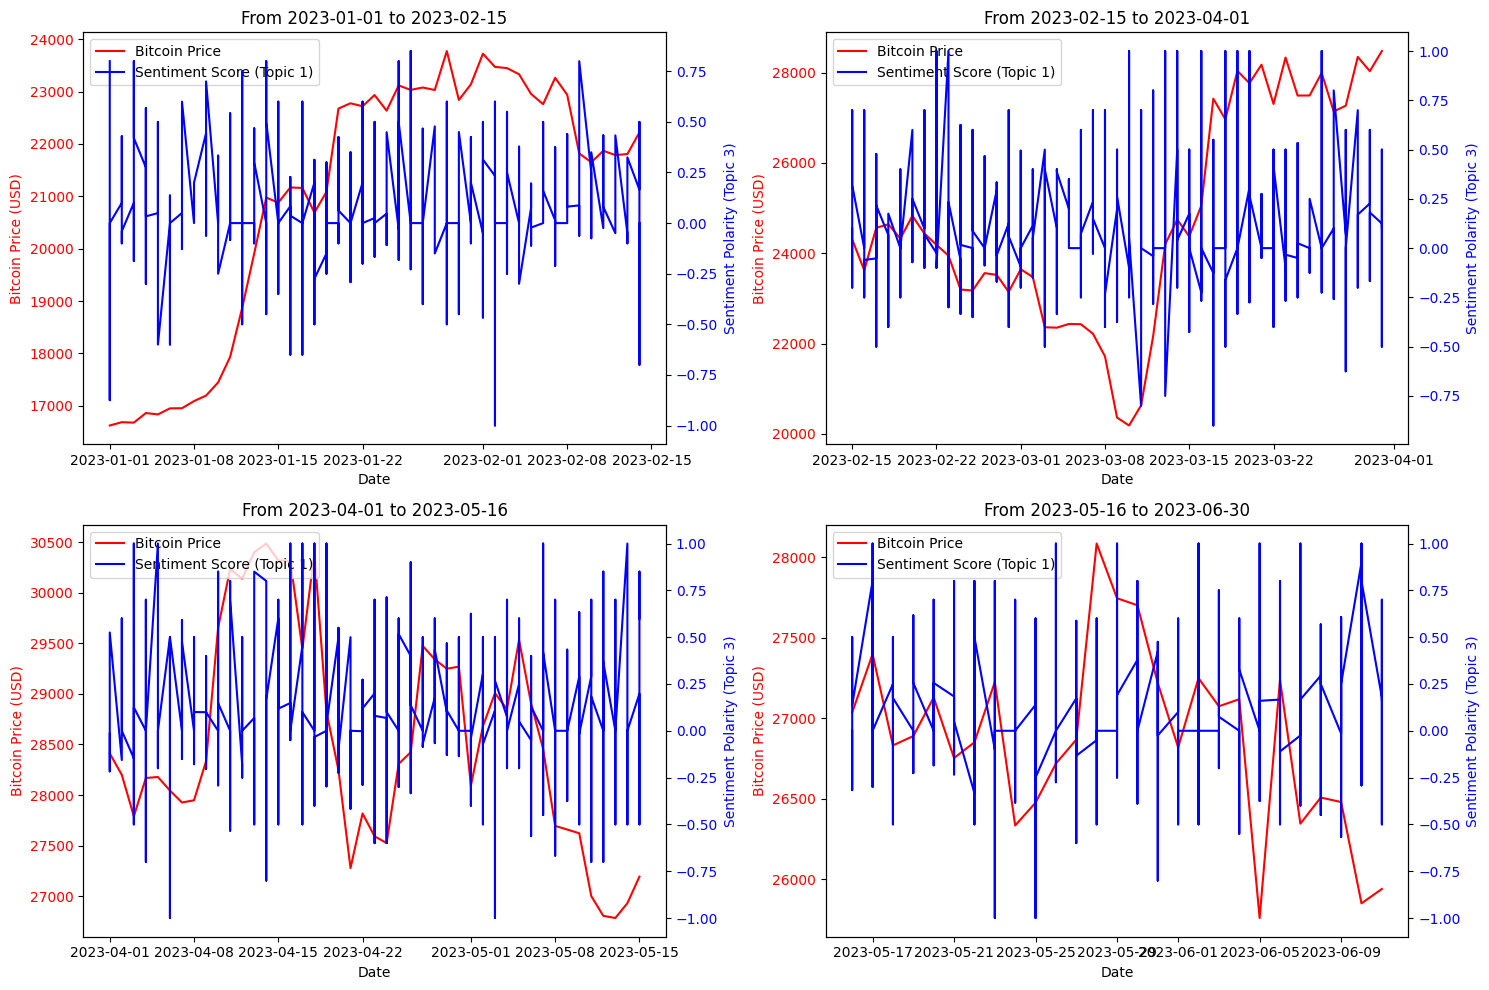

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd  # Assuming merged_data is a DataFrame

# Define the start date and calculate end dates for each interval
start_date = pd.to_datetime('2023-01-01')
end_dates = [start_date + pd.DateOffset(days=45*i) for i in range(1, 5)]

# Define periods with the calculated end dates, ensuring coverage until 2023-06-30
periods_2023 = [(start_date + pd.DateOffset(days=45*(i-1)), end_dates[i-1]) for i in range(1, 5)]

# Adjust the last period to end exactly on 2023-06-30
periods_2023[-1] = (periods_2023[-2][1], pd.to_datetime('2023-06-30'))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Loop through each period
for i, (start, end) in enumerate(periods_2023):
    # Filter data for the period
    period_data = merged_data[(merged_data['created_at'] >= start) & (merged_data['created_at'] < end)]

    # Filter data for topic 1
    topic_data = period_data[period_data['topic'] == 3]

    # Determine the subplot position
    row = i // 2
    col = i % 2

    # Plot Bitcoin prices and sentiment scores for topic 1
    ax = axs[row, col]
    ax.plot(topic_data['created_at'], topic_data['Close'], color='red', label='Bitcoin Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bitcoin Price (USD)', color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Create secondary y-axis for sentiment scores
    ax2 = ax.twinx()
    ax2.plot(topic_data['created_at'], topic_data['polarity'], color='blue', label='Sentiment Score (Topic 1)')
    ax2.set_ylabel('Sentiment Polarity (Topic 3)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add legend
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc='upper left')

    # Set title to include the start and end date of the period
    ax.set_title(f'From {start.date()} to {end.date()}')

# Adjust layout and display plot
plt.tight_layout()
plt.show()
